# MSDS 634 Deep Learning Final Project
## Plant Disease Image Classification
MSDS 634 Deep Learning Final Project

Professor Mustafa Hajij

Team Members:

|  |  |  |  |
| :---: | :---: | :---: | :---: |
| <img width="150" src='https://ca.slack-edge.com/E0273KBCB9P-U05FPRGA8K0-c0a8e7ead07b-512' />| <img width="150" src='https://ca.slack-edge.com/E0273KBCB9P-U04V6DJDE59-de77b0f72ec7-512' /> | <img width="150" src='https://ca.slack-edge.com/E0273KBCB9P-U05FFV3K7N3-92274156fb32-512' /> | <img width="150" src='https://ca.slack-edge.com/E0273KBCB9P-U05FFV8TLQ7-49771fc86756-512' /> |
|Amadeo Cabanela | Gaurav Goyal | Arios Tong | Jiaxuan Ouyang |








# EDA and Preprocessing

## Imports and Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import textwrap
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm # progress bar

In [ ]:
!pip install torchinfo

In [ ]:
!pip install pytz

## Decide which dataset version to use
The dataset comes with 3 versions: `color`, `grayscale`, and `segmented`. We'll need to choose one of them to use. Let's see sample images from each:

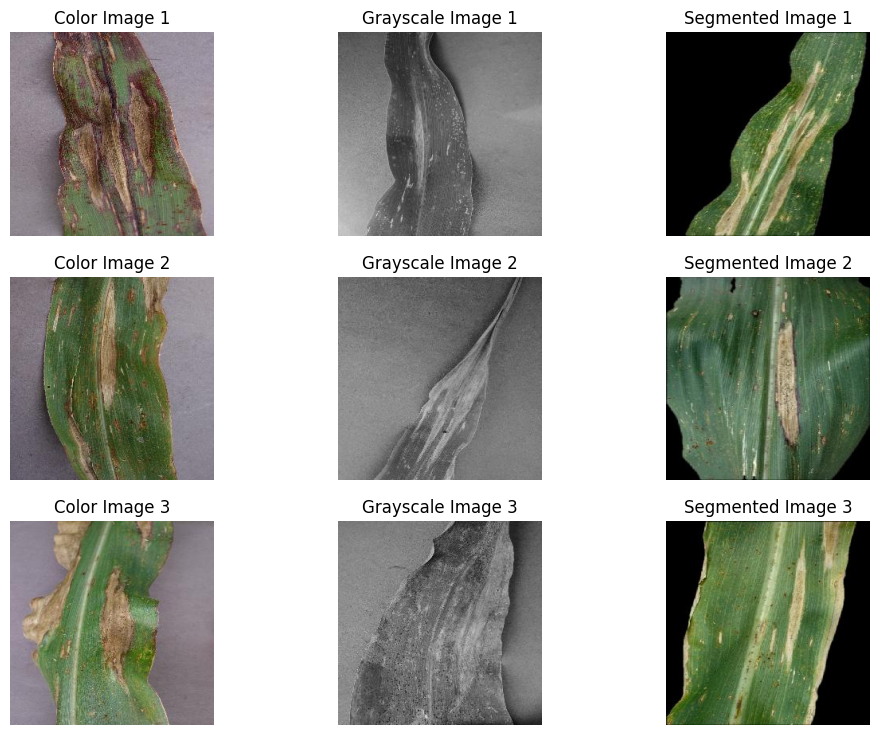

In [ ]:
def display_sample_images(color_dir, grayscale_dir, segmented_dir, num_images=3):
    color_files = os.listdir(color_dir)[:num_images]
    grayscale_files = os.listdir(grayscale_dir)[:num_images]
    segmented_files = os.listdir(segmented_dir)[:num_images]

    plt.figure(figsize=(12, 3*num_images))
    for i, (color_file, grayscale_file, segmented_file) in enumerate(zip(color_files, grayscale_files, segmented_files), start=1):

        plt.subplot(num_images, 3, i*3-2)
        color_img = mpimg.imread(os.path.join(color_dir, color_file))
        plt.imshow(color_img)
        plt.title(f'Color Image {i}')
        plt.axis('off')

        plt.subplot(num_images, 3, i*3-1)
        grayscale_img = mpimg.imread(os.path.join(grayscale_dir, grayscale_file))
        plt.imshow(grayscale_img, cmap='gray')
        plt.title(f'Grayscale Image {i}')
        plt.axis('off')

        plt.subplot(num_images, 3, i*3)
        segmented_img = mpimg.imread(os.path.join(segmented_dir, segmented_file))
        plt.imshow(segmented_img)
        plt.title(f'Segmented Image {i}')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

# Specify the directories for each dataset
base_dir = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/other/'
color_dir = base_dir + '/../color_corn/Corn_(maize)___Northern_Leaf_Blight'
grayscale_dir = base_dir + '/grayscale/Corn_(maize)___Northern_Leaf_Blight'
segmented_dir = base_dir + '/segmented/Corn_(maize)___Northern_Leaf_Blight'

# Display sample images from each dataset
display_sample_images(color_dir, grayscale_dir, segmented_dir)


Upon visual inspection of the sample images above, we observe the following about each dataset version:
* `color` - This seems like the raw, original RGB leaf images in color.
* `grayscale` - The leaf images in grayscale. There seems to be some other preprocessing done as there is higher contrast (i.e. the highlights and shadows are more prominent compared to the color version).
* `segmented` - The leaf images with some preprocessing applied including background removal and perhaps increased contrast.

**Using the `color` dataset:** Since the focus of this project is applying deep learning techniques, we would like the neural networks to learn features on their own without extensive preprocessing. Therefore, we will use the `color` version of the dataset.

## Address Outliers
Before we move foward with EDA, let's remove bad data. The Kaggle page gives the following information about the file type distribution:
* `.JPG`: 163k images
* `.png`: 2 images
* `.jpeg`: 2 images

Since there are only 4 images with different file formats out of 163k images, we can safely remove them. Let's find the paths/filenames of the files with `.png` and `.jpeg` extensions:

In [ ]:
!find /content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/other/color -name "*.png"

/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/other/color/Pepper,_bell___healthy/42f083e2-272d-4f83-ad9a-573ee90e50ec___Screen Shot 2015-05-06 at 4.01.13 PM.png


In [ ]:
!find /content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/other/color -name "*.jpeg"

/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/other/color/Tomato___Late_blight/d0badc95-d04c-457b-8db8-aa6e198f4bd6___GHLB Leaf 10 Day 6.jpeg


The .png and .jpeg images are for bell pepper and tomato. Since we are focusing on corn leaves, we can safely ignore these.



## Load Dataset

**Set up data directory:** Define the directory where the dataset is located.


In [ ]:
data_dir = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/color_corn'

**Load dataset:** We'll use PyTorch's `datasets.ImageFolder` class to load the dataset. This class automatically infers the classes from the folder structure. The images have a ".JPG" extension which is not accepted by default. Rather than update thousands of filenames, we'll implement a custom class that extends `datasets.ImageFolder` to accept this extension by overriding the `make_dataset()` method.

In [ ]:
class CustomImageFolder(datasets.ImageFolder):
    @staticmethod
    def make_dataset(directory, class_to_idx, extensions=None, is_valid_file=None):
        """
        Overridden method to create a dataset from the directory.
        """
        instances = []
        directory = os.path.expanduser(directory)
        if not ((extensions is None) or isinstance(extensions, str)):
            extensions = tuple(extensions)
        if extensions is not None:
            def is_valid_file(x):
                return datasets.folder.has_file_allowed_extension(x, extensions)
        else:
            def is_valid_file(x):
                return True
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(directory, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    if is_valid_file(path):
                        item = path, class_index
                        instances.append(item)
        return instances

In [ ]:
dataset = CustomImageFolder(root=data_dir)

## Exploratory Data Analysis (EDA)

We'll be working with the classes related to crops for the corn crop. Let's build an understanding of the images of different corn crops through EDA.

**Calculate dataset statistics:** Let's get some basic statistics about the grape leaves image dataset, such as the number of classes, number of samples per class, and overall dataset size.

In [ ]:
num_classes = len(dataset.classes)
class_names = dataset.classes
class_counts = np.bincount(dataset.targets)
dataset_size = len(dataset)
print("Dataset Statistics:")
print("-------------------")
print(f"Number of classes: {num_classes}")
print("Class Names:")
for idx, class_name in enumerate(class_names):
    print(f"  Class {idx}: {class_name}")
print("Class Counts:")
for idx, class_count in enumerate(class_counts):
    print(f"  Class {idx}: {class_count}")
print(f"Total number of samples: {dataset_size}")

Dataset Statistics:
-------------------
Number of classes: 4
Class Names:
  Class 0: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
  Class 1: Corn_(maize)___Common_rust_
  Class 2: Corn_(maize)___Northern_Leaf_Blight
  Class 3: Corn_(maize)___healthy
Class Counts:
  Class 0: 513
  Class 1: 1192
  Class 2: 985
  Class 3: 1162
Total number of samples: 3852


**Plot class distribution:** From the class distribution plot below, we can see that there is class imbalance.

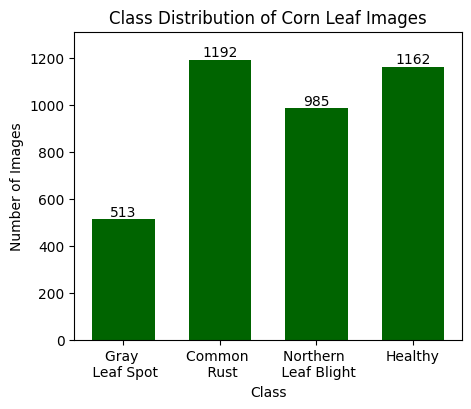

In [ ]:
plot_class_names = ['Gray \n Leaf Spot', 'Common \n Rust', 'Northern \n Leaf Blight', 'Healthy']

plt.figure(figsize=(5, 4))
bars = plt.bar(plot_class_names, class_counts, color='darkgreen', width=0.65)

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Corn Leaf Images')

# Add counts above each bar
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

# Adjust y-axis limits to add space above the bars
plt.ylim(0, max(class_counts) * 1.1)  # Add 10% space above the tallest bar

# Save the plot as a PNG with transparent background
plt.savefig('class_distribution.png', transparent=True, bbox_inches='tight')

plt.show()

**Visualize sample images:** Let's plot a few sample images from each class to get a sense of what the images look like.

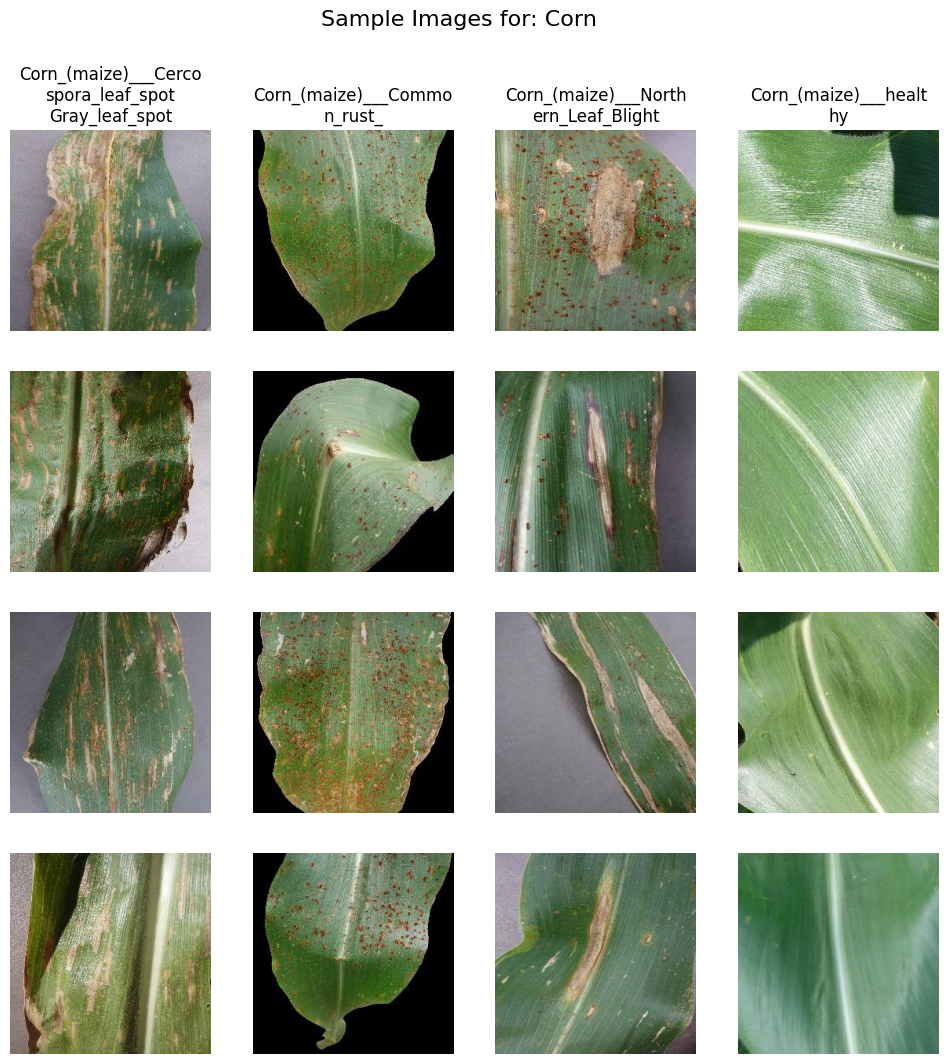

In [ ]:
crop_name = 'Corn'

# Get the corn subclass names
subclass_names = []
for subclass_name in dataset.classes:
    if subclass_name.startswith(crop_name):
        subclass_names.append(subclass_name)

num_samples_per_subclass = 4
num_subclasses = len(subclass_names)
num_columns = num_subclasses
num_rows = num_samples_per_subclass

fig, axes = plt.subplots(num_rows, num_columns, figsize=(3*num_columns, 3*num_rows),
                          gridspec_kw={'hspace': 0.2, 'wspace': 0.2})  # Adjust spacing between subplots
fig.suptitle(f"Sample Images for: {crop_name}", fontsize=16)

for i, subclass_name in enumerate(subclass_names):
    subclass_indices = [idx for idx, label in enumerate(dataset.targets) if dataset.classes[label].startswith(crop_name) and subclass_name in dataset.classes[label]]
    if len(subclass_indices) == 0:
        print(f"No samples found for subclass '{subclass_name}'")
        continue
    sample_indices = np.random.choice(subclass_indices, min(num_samples_per_subclass, len(subclass_indices)), replace=False)
    for j, idx in enumerate(sample_indices):
        image, _ = dataset[idx]
        # Convert the PIL image to numpy array
        image_np = np.array(image)
        axes[j, i % num_columns].imshow(image_np)
        axes[j, i % num_columns].axis('off')
        # Add subclass title to the first row of images
        if j == 0:
            # Wrap title if it's longer than 20 characters
            wrapped_title = '\n'.join(textwrap.wrap(subclass_name, width=20))
            axes[j, i % num_columns].set_title(wrapped_title)

plt.show()

We can see that the Common Rust class has a black background, but the Healthy class has no background since the images are up close to the leaves. It will be interesting to see if the neural networks are still able to discern different disease types despite the background color differences.

## Decide Train/Val/Test Split Ratio

Let's consider the following to determine a train/val/test split ratio for our experiments:

* **Class Imbalance:** Since there is a significant variation in the number of images per class, it's essential to ensure that each class is adequately represented in both the training and validation sets to prevent bias towards classes with more data. Therefore, we should employ stratified sampling to maintain the class distribution across the splits.
* **Common Ratios:** Commonly used split ratios include 80% for training, 10% for validation, and 10% for testing. However, given the imbalance in class sizes, it might be beneficial to allocate a higher proportion of data to the validation and testing sets to ensure better representation of each class.

**Final Split Ratio:** With this in mind, we'll use the following split ratio:
* Train set: 70%
* Validation set: 15%
* Test set: 15%

This split ratio ensures sufficient data for training while still providing an adequate number of samples for validation and testing.

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Create the ImageFolder dataset
dataset = CustomImageFolder(root=data_dir, transform=transform)

# Get the targets (labels) and class indices
targets = [label for _, label in dataset.samples]
class_indices = {class_name: i for i, class_name in enumerate(dataset.classes)}

# Perform stratified split
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    range(len(dataset)), targets, test_size=0.3, stratify=targets, random_state=634)

val_indices, test_indices, val_labels, test_labels = train_test_split(
    temp_indices, temp_labels, test_size=0.5, stratify=temp_labels, random_state=634)

# Create datasets using the split indices
train_data = torch.utils.data.Subset(dataset, train_indices)
val_data = torch.utils.data.Subset(dataset, val_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)

# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# Print dataset sizes
print(f"Train dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")
print(f"Test dataset size: {len(test_data)}")

Train dataset size: 2696
Validation dataset size: 578
Test dataset size: 578


## Data Preprocessing
We'll do the following steps to prepare our data for modeling:
1. Normalization according to dataset mean and standard deviation of each color channel. To prevent data leakage, these stats must be calculated from the images in the train set and applied to the train, val and test sets.
1. Resize images to 256x256
1. Save preprocessed image data as numpy files for train, validation, and test

**Calculate mean and standard deviation of RGB channels:** An important preprocessing step for image classification will be normalizing the images. Let's calculate the the mean and standard deviation of each color channel in the train set using sampled images per class. Then we will normalize the images with this information.

In [ ]:
# Initialize arrays to store images, widths, heights, and color channel values
images = np.empty((0, 3, 256, 256), dtype=np.float32)
widths = np.empty(0, dtype=np.int32)
heights = np.empty(0, dtype=np.int32)

for batch_images, _ in tqdm(train_loader, desc="Calculating Mean and Std from Train, processing batches", leave=False):
    # Convert batch images to numpy arrays
    batch_images_np = batch_images.numpy()
    # Append batch images to the array of images
    images = np.concatenate((images, batch_images_np), axis=0)
    # Get batch widths and heights
    batch_widths = batch_images_np.shape[2]
    batch_heights = batch_images_np.shape[3]
    # Append batch widths and heights to the respective arrays
    widths = np.concatenate((widths, np.full(batch_images_np.shape[0], batch_widths, dtype=np.int32)))
    heights = np.concatenate((heights, np.full(batch_images_np.shape[0], batch_heights, dtype=np.int32)))

# Calculate mean and standard deviation for each channel
mean_width = np.mean(widths)
mean_height = np.mean(heights)
mean_per_channel = np.mean(images, axis=(0, 2, 3))
std_per_channel = np.std(images, axis=(0, 2, 3))

# Print mean and standard deviation for each channel
print("Statistics for Train Set:")
print("=================================")
print("Mean Width:", mean_width)
print("Mean Height:", mean_height)
print("Mean per channel:", mean_per_channel)
print("Standard deviation per channel:", std_per_channel)


Statistics for Train Set:
Mean Width: 256.0
Mean Height: 256.0
Mean per channel: [0.43613595 0.4974372  0.3781651 ]
Standard deviation per channel: [0.21189487 0.22010513 0.21154968]


**Define and apply transformations:** Define the transformations we'll apply to the images. These transformations will include resizing and normalization according to the mean width/height, and mean/standard deviations of each color channel we just calculated.

In [ ]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.43613595, 0.4974372, 0.3781651],
                         std=[0.21189487, 0.22010513, 0.21154968]),  # Normalize using mean and std
])

# Apply transformations to datasets
train_data.transform = transform
val_data.transform = transform
test_data.transform = transform

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

**Save preprocessed data as numpy files:** We'll be saving our preprocessed data as numpy files to be loaded for model training later. There are several benefits to saving the loading numpy files instead of loading .JPG files with datasets.ImageFolder:
* We can take advantagge of vectorization with numpy data.
* Loading data from a single numpy file involves fewer I/O operations compared to loading multiple image files from disk, which can lead to faster data loading times.
* This efficiencies will make a significant difference in model processing time.

In [ ]:
# Function to save data and labels as numpy files
def save_as_numpy(loader, save_dir, name):
    num_samples = len(loader.dataset)
    data_array = np.empty((num_samples, 3, 256, 256), dtype=np.float32)
    label_array = np.empty((num_samples,), dtype=np.int32)

    index = 0
    # Use tqdm to create a progress bar for the iteration
    with tqdm(total=num_samples, desc=f"Saving {name} data") as pbar:
        for batch_idx, (data, labels) in enumerate(loader):
            batch_size = len(data)
            data_array[index:index+batch_size] = data.numpy()
            label_array[index:index+batch_size] = labels.numpy()
            index += batch_size
            pbar.update(batch_size)  # Update the progress bar
            pbar.set_postfix(batch=batch_idx)  # Update the batch number

    np.save(os.path.join(save_dir, f"{name}_data.npy"), data_array)
    np.save(os.path.join(save_dir, f"{name}_labels.npy"), label_array)

# Define the directory to save the numpy files
save_dir = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn'

# Save train, validation, and test sets
save_as_numpy(train_loader, save_dir, 'train')
save_as_numpy(val_loader, save_dir, 'val')
save_as_numpy(test_loader, save_dir, 'test')

Saving test data: 100%|██████████| 578/578 [02:28<00:00,  3.89it/s, batch=9]


**Resize images to 224 x 224:** Some models expect iamges with size 224x224, but our images are originally 256x256. We'll need to resize them and save them as numpy files. Instead of cropping the images, we'll use linear interpolation to preserve the image information. Instead of holding multiple arrays in memory, we'll load each numpy array, to save memory, manipulate the variable in-place, then save it as a new numpy file.

In [ ]:
# Load the original image data
original_train_image_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn/train_data.npy')
# original_val_image_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn/val_data.npy')
# original_test_image_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn/test_data.npy')
print("original_train_image_data.shape BEFORE: ", original_train_image_data.shape)

# Resize the image data in-place
target_size = (224, 224)  # Desired new size of the image
num_images = original_train_image_data.shape[0]  # Image data is stored in an array of shape (num_images, channels, height, width)

# Initialize tqdm progress bar
progress_bar = tqdm(total=num_images, desc="Resizing images")

for i in range(num_images):
    # Resize the image
    resized_image = cv2.resize(original_train_image_data[i].transpose(1, 2, 0), target_size, interpolation=cv2.INTER_LINEAR)

    # Transpose the dimensions back to (channels, height, width)
    resized_image = resized_image.transpose(2, 0, 1)

    # Update the original image data with the resized image
    original_train_image_data[i, :, :resized_image.shape[1], :resized_image.shape[2]] = resized_image

    progress_bar.update(1)  # Update progress bar

progress_bar.close()  # Close progress bar

# Crop the entire original_train_image_data array
original_train_image_data = original_train_image_data[:, :, :224, :224]

# Now 'original_train_image_data' contains the resized and cropped image data with shape (num_images, channels, 224, 224)
print("original_train_image_data.shape AFTER: ", original_train_image_data.shape)

# Define the path for saving the resized image data
output_path = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_data_resized_224.npy'
# output_path = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_data_resized_224.npy'
# output_path = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/test_data_resized_224.npy'

# Save the resized and cropped image data to a new file
np.save(output_path, original_train_image_data)

# Release the memory
del original_train_image_data

print("Resized and cropped image data saved to:", output_path)


original_train_image_data.shape BEFORE:  (2696, 3, 256, 256)


Resizing images: 100%|██████████| 2696/2696 [00:03<00:00, 694.13it/s]


original_train_image_data.shape AFTER:  (2696, 3, 224, 224)
Resized and cropped image data saved to: /content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_data_resized_224.npy


**Plot Sample Preprocessed Images:** Let's load the data and plot a sample image.

In [ ]:
# Load the numpy files
train_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_data_resized_224.npy')
train_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_labels.npy')
val_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_data_resized_224.npy')
val_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_labels.npy')
test_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/test_data_resized_224.npy')
test_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/test_labels.npy')

Let's display a sample image as a sanity check to make sure we loaded the data properly:

train_sample_image.shape:  (3, 224, 224)


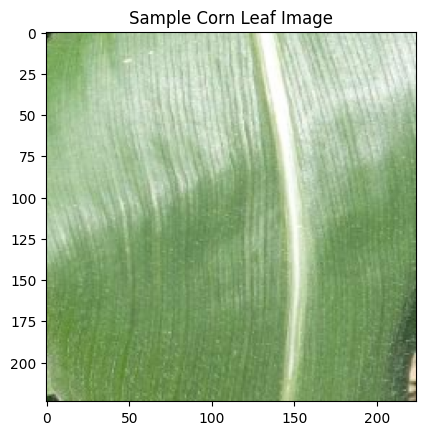

In [ ]:
train_sample_image = train_data[10]
print("train_sample_image.shape: ", train_sample_image.shape)

# Display the sample image
plt.imshow(train_sample_image.transpose(1, 2, 0))  # Transpose the dimensions for displaying with matplotlib
plt.title('Sample Corn Leaf Image')
plt.show()


val_sample_image.shape:  (3, 224, 224)


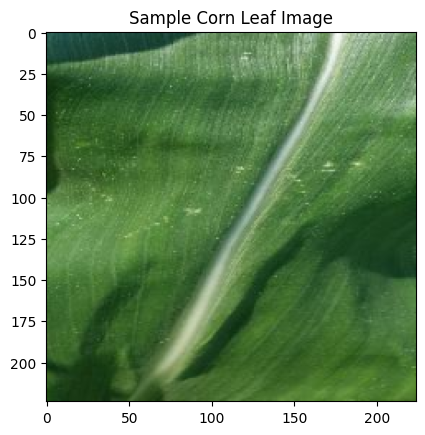

In [ ]:
val_sample_image = val_data[10]
print("val_sample_image.shape: ", val_sample_image.shape)

# Display the sample image
plt.imshow(val_sample_image.transpose(1, 2, 0))  # Transpose the dimensions for displaying with matplotlib
plt.title('Sample Corn Leaf Image')
plt.show()


**Plot Data Distributions:** Now that we've saved our preprocessed data splits, let's their class distributions.

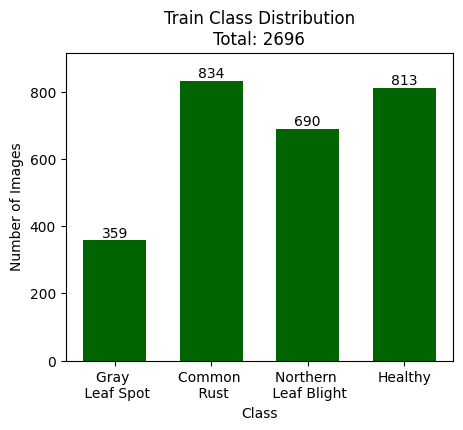

In [ ]:
# Plot Train Distribution
plot_class_names = ['Gray \n Leaf Spot', 'Common \n Rust', 'Northern \n Leaf Blight', 'Healthy']
train_class_counts = np.bincount(train_labels)
train_dataset_size = len(train_labels)

plt.figure(figsize=(5, 4))
bars = plt.bar(plot_class_names, train_class_counts, color='darkgreen', width=0.65)

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title(f'Train Class Distribution\nTotal: {train_dataset_size}')

# Add counts above each bar
for bar, count in zip(bars, train_class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

# Adjust y-axis limits to add space above the bars
plt.ylim(0, max(train_class_counts) * 1.1)  # Add 10% space above the tallest bar

# Save the plot as a PNG with transparent background
plt.savefig('train_class_distribution.png', transparent=True, bbox_inches='tight')

plt.show()

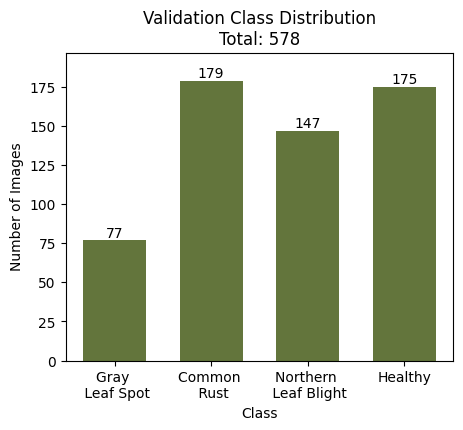

In [ ]:
# Plot Val Distribution
plot_class_names = ['Gray \n Leaf Spot', 'Common \n Rust', 'Northern \n Leaf Blight', 'Healthy']
val_class_counts = np.bincount(val_labels)
val_dataset_size = len(val_labels)

plt.figure(figsize=(5, 4))
bars = plt.bar(plot_class_names, val_class_counts, color='#63753c', width=0.65)

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title(f'Validation Class Distribution\nTotal: {val_dataset_size}')

# Add counts above each bar
for bar, count in zip(bars, val_class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

# Adjust y-axis limits to add space above the bars
plt.ylim(0, max(val_class_counts) * 1.1)  # Add 10% space above the tallest bar

# Save the plot as a PNG with transparent background
plt.savefig('val_class_distribution.png', transparent=True, bbox_inches='tight')

plt.show()

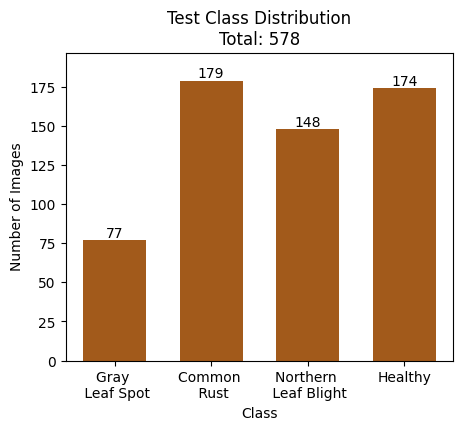

In [ ]:
# Plot Test Distribution
plot_class_names = ['Gray \n Leaf Spot', 'Common \n Rust', 'Northern \n Leaf Blight', 'Healthy']
test_class_counts = np.bincount(test_labels)
test_dataset_size = len(test_labels)

plt.figure(figsize=(5, 4))
bars = plt.bar(plot_class_names, test_class_counts, color='#a25a1b', width=0.65)

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title(f'Test Class Distribution\nTotal: {test_dataset_size}')

# Add counts above each bar
for bar, count in zip(bars, test_class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

# Adjust y-axis limits to add space above the bars
plt.ylim(0, max(test_class_counts) * 1.1)  # Add 10% space above the tallest bar

# Save the plot as a PNG with transparent background
plt.savefig('test_class_distribution.png', transparent=True, bbox_inches='tight')

plt.show()

## Summary of EDA Takeaways
Here are the main takeaways from EDA and how it will inform our model experiments:

1. **Class Imbalance** - Our dataset has significant data imbalance across 4 corn subclasses. To address this, instead of undersampling (losing data) or oversampling (will increase processing time and requires more compute power), we'll need to use the class weights when training the model.
2. **Using F1 Score as our primary metric** - Since we have an imbalanced dataset, we shouldn't use accuracy. We'll use F1 score as our primary evaluation metric for selecting our best models since it balances between precision and recall, accounting for imbalanced datasets.

# Model Experiments

## Baseline Model

Since this is a deep learning course, we'll be using a simple/shallow neural network with one hidden layer as our baseline model that will serve as a benchmark for the rest of our model experiments. Since this is a baseline model, there will be no special hyperparameter configuration and default values will be used.

### Load Preprocessed Dataset

In [ ]:
# Load the numpy files
train_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn/train_data.npy')
train_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn/train_labels.npy')
val_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn/val_data.npy')
val_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn/val_labels.npy')

# Convert numpy arrays to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
val_dataset = TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_labels))

# Define data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Here we define our baseline model:

In [ ]:
# Define the shallow neural network model
class ShallowNN(nn.Module):
    def __init__(self):
        super(ShallowNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 256 * 256, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = ShallowNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Let's now train the model:

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_predictions = []
    train_targets = []
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_targets.extend(labels.tolist())

    # Calculate train f1_score and loss
    train_loss /= len(train_loader)
    train_f1 = f1_score(train_targets, train_predictions, average='weighted')

    # Evaluate the model on validation set
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for data, labels in val_loader:
            outputs = model(data)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    # Calculate validation f1_score and loss
    val_loss /= len(val_loader)
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1 Score: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1 Score: {val_f1:.4f}')


Epoch 1/10, Train Loss: 10.9398, Train F1 Score: 0.5237, Val Loss: 0.5262, Val F1 Score: 0.7904
Epoch 2/10, Train Loss: 0.8909, Train F1 Score: 0.7591, Val Loss: 0.7020, Val F1 Score: 0.7260
Epoch 3/10, Train Loss: 1.2719, Train F1 Score: 0.7748, Val Loss: 6.1403, Val F1 Score: 0.4500
Epoch 4/10, Train Loss: 2.9372, Train F1 Score: 0.6776, Val Loss: 1.0821, Val F1 Score: 0.7791
Epoch 5/10, Train Loss: 0.9236, Train F1 Score: 0.7993, Val Loss: 0.4563, Val F1 Score: 0.8341
Epoch 6/10, Train Loss: 0.3923, Train F1 Score: 0.8688, Val Loss: 1.4244, Val F1 Score: 0.6190
Epoch 7/10, Train Loss: 0.5958, Train F1 Score: 0.8271, Val Loss: 0.4374, Val F1 Score: 0.8408
Epoch 8/10, Train Loss: 0.5149, Train F1 Score: 0.8457, Val Loss: 0.4800, Val F1 Score: 0.8064
Epoch 9/10, Train Loss: 0.2877, Train F1 Score: 0.8907, Val Loss: 0.6118, Val F1 Score: 0.7300
Epoch 10/10, Train Loss: 0.5108, Train F1 Score: 0.8416, Val Loss: 1.5340, Val F1 Score: 0.7553


In [ ]:
from sklearn.metrics import precision_score, recall_score

# Evaluate the model on the train set
model.eval()
train_predictions = []
train_targets = []
train_loss = 0.0
with torch.no_grad():
    for data, labels in train_loader:
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_targets.extend(labels.tolist())

# Calculate train loss and F1 score
train_loss /= len(train_loader)
train_f1 = f1_score(train_targets, train_predictions, average='weighted')

print(f'Train Loss: {train_loss:.4f}, Train F1 Score: {train_f1:.4f}')

# Calculate train precision and recall
train_precision = precision_score(train_targets, train_predictions, average='weighted')
train_recall = recall_score(train_targets, train_predictions, average='weighted')

print(f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}')

Train Loss: 1.3388, Train F1 Score: 0.7795
Train Precision: 0.7540, Train Recall: 0.8275


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import precision_score, recall_score

# Evaluate the model on the validation set
model.eval()
val_predictions = []
val_targets = []
val_loss = 0.0
with torch.no_grad():
    for data, labels in val_loader:
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.tolist())
        val_targets.extend(labels.tolist())

# Calculate validation loss and F1 score
val_loss /= len(val_loader)
val_f1 = f1_score(val_targets, val_predictions, average='weighted')

print(f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}')

# Calculate val precision and recall
val_precision = precision_score(val_targets, val_predictions, average='weighted')
val_recall = recall_score(val_targets, val_predictions, average='weighted')

print(f'Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}')

Validation Loss: 1.5340, Validation F1 Score: 0.7553
Val Precision: 0.7375, Val Recall: 0.7993


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Calculating Class Weights
To address the imbalanced data without having to oversampling/adding more images to our train dataset, we can use class weights and pass that into the loss function. See this article for more info: https://naadispeaks.blog/2021/07/31/handling-imbalanced-classes-with-weighted-loss-in-pytorch/

We'll calculate the class weights using the following formula:
$$ \text{class_weight} = 1 - \frac{\text{number of samples of the class}}{\text{total number of samples}} $$

**Class weights don't have to sum to 1:** You might notice that the class weights below using the formula above don't sum to 1. The class weights used in the weight parameter of `CrossEntropyLoss()` in PyTorch do not need to sum to 1.
* The class weights are used to adjust the contribution of each class's loss to the overall loss during training. These weights are directly multiplied with the losses calculated for each class, effectively scaling the loss for each class according to the provided weights.
* Therefore, the class weights should reflect the relative importance or significance of each class in your dataset, but they do not need to sum to 1. The absolute values of the weights are what matter; their relative magnitudes determine the impact on the loss calculation.

In [ ]:
# Calculate class frequencies
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Calculate total number of samples
total_samples = len(train_labels)

# Calculate class weights using the provided formula
class_weights_dict = {cls: 1 - (count / total_samples) for cls, count in zip(unique_classes, class_counts)}
class_weights = list(class_weights_dict.values())

print("Class weights:", class_weights)

Class weights: [0.8668397626112759, 0.6906528189910979, 0.7440652818991098, 0.6984421364985163]


Now we can pass in these class weights into the loss function to account for the class imbalance. Then we can run our training loop as usual!
```
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))
```

## Experiment 1.1: Initial CNN Model


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import pandas as pd

class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, num_classes, device, save_path, model_name):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float, device=device))
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.train_losses = []
        self.val_losses = []
        self.train_f1_scores = []
        self.val_f1_scores = []
        self.save_path = save_path
        self.model_name = model_name

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            self.model.train()
            total_train_loss = 0
            all_train_labels = []
            all_train_preds = []

            for data, labels in self.train_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.criterion(outputs, labels.long())
                loss.backward()
                self.optimizer.step()

                total_train_loss += loss.item()
                all_train_labels.extend(labels.cpu().numpy())
                all_train_preds.extend(torch.max(outputs, 1)[1].cpu().numpy())

            train_loss = total_train_loss / len(self.train_loader)
            train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
            self.train_losses.append(train_loss)
            self.train_f1_scores.append(train_f1)

            val_loss, val_f1 = self.validate()
            self.val_losses.append(val_loss)
            self.val_f1_scores.append(val_f1)

            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

        self.save_model()
        self.save_losses()

    def validate(self):
        self.model.eval()
        total_val_loss = 0
        all_val_labels = []
        all_val_preds = []
        with torch.no_grad():
            for data, labels in self.val_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                outputs = self.model(data)
                loss = self.criterion(outputs, labels.long())
                total_val_loss += loss.item()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(torch.max(outputs, 1)[1].cpu().numpy())

        val_loss = total_val_loss / len(self.val_loader)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        return val_loss, val_f1

    def save_model(self):
        model_save_path = os.path.join(self.save_path, f'{self.model_name}_model.pth')
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'model_architecture': self.model
        }, model_save_path)
        print(f"Model saved to {model_save_path}")

    def save_losses(self):
        losses_save_path = os.path.join(self.save_path, f'{self.model_name}_train_val_losses.csv')
        data = {
            "Epoch": range(1, len(self.train_losses) + 1),
            "Train Loss": self.train_losses,
            "Train F1": self.train_f1_scores,
            "Validation Loss": self.val_losses,
            "Validation F1": self.val_f1_scores
        }
        df = pd.DataFrame(data)
        df.to_csv(losses_save_path, index=False)
        print(f"Loss and F1 data saved to {losses_save_path}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=4)
save_path = '/content/drive/MyDrive/DLdata2/models_data'
model_name = 'cnn_v2'
trainer = ModelTrainer(model, train_loader, val_loader, num_classes=4, device=device, save_path=save_path, model_name=model_name)
trainer.train(num_epochs=10)


Epoch 1/10, Train Loss: 0.6641, Train F1: 0.7325, Val Loss: 0.5671, Val F1: 0.7769
Epoch 2/10, Train Loss: 0.3737, Train F1: 0.8301, Val Loss: 0.2595, Val F1: 0.8796
Epoch 3/10, Train Loss: 0.2579, Train F1: 0.8926, Val Loss: 0.3145, Val F1: 0.8588
Epoch 4/10, Train Loss: 0.2041, Train F1: 0.9131, Val Loss: 0.4621, Val F1: 0.8361
Epoch 5/10, Train Loss: 0.1853, Train F1: 0.9234, Val Loss: 0.2299, Val F1: 0.9326
Epoch 6/10, Train Loss: 0.1725, Train F1: 0.9397, Val Loss: 0.2833, Val F1: 0.9253
Epoch 7/10, Train Loss: 0.1478, Train F1: 0.9428, Val Loss: 0.2327, Val F1: 0.9306
Epoch 8/10, Train Loss: 0.1297, Train F1: 0.9496, Val Loss: 0.2143, Val F1: 0.9418
Epoch 9/10, Train Loss: 0.0806, Train F1: 0.9714, Val Loss: 0.3027, Val F1: 0.9215
Epoch 10/10, Train Loss: 0.0759, Train F1: 0.9751, Val Loss: 0.2980, Val F1: 0.9325
Model saved to /content/drive/MyDrive/DLdata2/models_data/cnn_v2_model.pth
Loss and F1 data saved to /content/drive/MyDrive/DLdata2/models_data/cnn_v2_train_val_losses.c

## Experiment 1.2: CNN Model 2


In [ ]:

class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v2 = CNNModel(num_classes=4)
save_path = '/content/drive/MyDrive/DLdata2/models_data'
model_name = 'cnn_v3'

# Instantiate the ModelTrainer with the new model
trainer_v2 = ModelTrainer(model_v2, train_loader, val_loader, num_classes=4, device=device, save_path=save_path, model_name=model_name)

# Train the model
trainer_v2.train(num_epochs=10)


Epoch 1/10, Train Loss: 0.7187, Train F1: 0.6813, Val Loss: 0.3503, Val F1: 0.8504
Epoch 2/10, Train Loss: 0.2812, Train F1: 0.8676, Val Loss: 0.4145, Val F1: 0.8338
Epoch 3/10, Train Loss: 0.2580, Train F1: 0.8928, Val Loss: 1.8050, Val F1: 0.5989
Epoch 4/10, Train Loss: 0.2793, Train F1: 0.8851, Val Loss: 0.3394, Val F1: 0.8579
Epoch 5/10, Train Loss: 0.1828, Train F1: 0.9348, Val Loss: 0.2612, Val F1: 0.9318
Epoch 6/10, Train Loss: 0.1409, Train F1: 0.9487, Val Loss: 0.2817, Val F1: 0.9396
Epoch 7/10, Train Loss: 0.1188, Train F1: 0.9578, Val Loss: 0.3567, Val F1: 0.9187
Epoch 8/10, Train Loss: 0.1318, Train F1: 0.9549, Val Loss: 0.3409, Val F1: 0.9190
Epoch 9/10, Train Loss: 0.1054, Train F1: 0.9661, Val Loss: 0.3859, Val F1: 0.9167
Epoch 10/10, Train Loss: 0.0883, Train F1: 0.9711, Val Loss: 0.3050, Val F1: 0.9031
Model saved to /content/drive/MyDrive/DLdata2/models_data/cnn_v3_model.pth
Loss and F1 data saved to /content/drive/MyDrive/DLdata2/models_data/cnn_v3_train_val_losses.c

## Experiment 2: ResNet Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)  # Adjust the number of output classes to 4

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# Only optimize the parameters of the final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 78.6MB/s]


In [ ]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, num_classes, device, save_path, model_name):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.save_path = save_path
        self.model_name = model_name
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
        self.train_losses = []
        self.val_losses = []
        self.train_f1_scores = []
        self.val_f1_scores = []

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            self.model.train()
            total_train_loss = 0
            all_train_labels, all_train_preds = [], []

            for data, labels in self.train_loader:
                data, labels = data.to(self.device), labels.to(self.device).long()  # Convert labels to long

                self.optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                total_train_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_train_labels.extend(labels.cpu().numpy())
                all_train_preds.extend(preds.cpu().numpy())

            train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
            self.train_losses.append(total_train_loss / len(self.train_loader))
            self.train_f1_scores.append(train_f1)

            # Validation phase
            model.eval()
            total_val_loss = 0
            all_val_labels, all_val_preds = [], []
            with torch.no_grad():
                for data, labels in self.val_loader:
                    data, labels = data.to(self.device), labels.to(self.device).long()  # Convert labels to long
                    outputs = self.model(data)
                    val_loss = self.criterion(outputs, labels)
                    total_val_loss += val_loss.item()
                    _, preds = torch.max(outputs, 1)
                    all_val_labels.extend(labels.cpu().numpy())
                    all_val_preds.extend(preds.cpu().numpy())

            val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
            self.val_losses.append(total_val_loss / len(self.val_loader))
            self.val_f1_scores.append(val_f1)

            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {self.train_losses[-1]:.4f}, Train F1: {train_f1:.4f}, Val Loss: {self.val_losses[-1]:.4f}, Val F1: {val_f1:.4f}')

        # Saving model and loss metrics
        self.save_model()
        self.save_losses()

    def save_model(self):
        model_path = f'{self.save_path}/{self.model_name}_model.pth'
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'model_architecture': self.model
        }, model_path)
        print(f"Model saved to {model_path}")

    def save_losses(self):
        losses_path = f'{self.save_path}/{self.model_name}_losses.csv'
        pd.DataFrame({
            'Epoch': range(1, len(self.train_losses) + 1),
            'Train Loss': self.train_losses,
            'Validation Loss': self.val_losses,
            'Train F1': self.train_f1_scores,
            'Validation F1': self.val_f1_scores
        }).to_csv(losses_path, index=False)
        print(f"Losses saved to {losses_path}")



In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
save_path = '/content/drive/MyDrive/DLdata2/models_data'
model_name = 'resnet_v1'
# Create the trainer instance
trainer = ModelTrainer(model, train_loader, val_loader, num_classes=4, device=device, save_path=save_path, model_name=model_name)

# Train the model
trainer.train(num_epochs=10)


Epoch 1/10, Train Loss: 0.1385, Train F1: 0.9501, Val Loss: 0.1149, Val F1: 0.9439
Epoch 2/10, Train Loss: 0.1211, Train F1: 0.9556, Val Loss: 0.1125, Val F1: 0.9607
Epoch 3/10, Train Loss: 0.1025, Train F1: 0.9596, Val Loss: 0.0997, Val F1: 0.9500
Epoch 4/10, Train Loss: 0.1082, Train F1: 0.9603, Val Loss: 0.0987, Val F1: 0.9567
Epoch 5/10, Train Loss: 0.0958, Train F1: 0.9637, Val Loss: 0.1035, Val F1: 0.9554
Epoch 6/10, Train Loss: 0.0935, Train F1: 0.9651, Val Loss: 0.1033, Val F1: 0.9614
Epoch 7/10, Train Loss: 0.0995, Train F1: 0.9634, Val Loss: 0.0973, Val F1: 0.9584
Epoch 8/10, Train Loss: 0.0980, Train F1: 0.9619, Val Loss: 0.0950, Val F1: 0.9533
Epoch 9/10, Train Loss: 0.0842, Train F1: 0.9691, Val Loss: 0.1055, Val F1: 0.9555
Epoch 10/10, Train Loss: 0.0865, Train F1: 0.9667, Val Loss: 0.0931, Val F1: 0.9583
Model saved to /content/drive/MyDrive/DLdata2/models_data/resnet_v1_model.pth
Losses saved to /content/drive/MyDrive/DLdata2/models_data/resnet_v1_losses.csv


## Experiment 3: ResNext Model


In [ ]:
# Load the pre-trained ResNeXt-50-32x4d model
model = models.resnext50_32x4d(pretrained=True)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match the number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)  # Adjust to your number of classes 4

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer for the fully connected layer
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 141MB/s]


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
save_path = '/content/drive/MyDrive/DLdata2/models_data'
model_name = 'resnet50_v1'
# Create the trainer instance
trainer = ModelTrainer(model, train_loader, val_loader, num_classes=4, device=device, save_path=save_path, model_name=model_name)

# Train the model
trainer.train(num_epochs=10)


Epoch 1/10, Train Loss: 0.6349, Train F1: 0.7859, Val Loss: 0.3146, Val F1: 0.8756
Epoch 2/10, Train Loss: 0.2630, Train F1: 0.9286, Val Loss: 0.1957, Val F1: 0.9343
Epoch 3/10, Train Loss: 0.2005, Train F1: 0.9419, Val Loss: 0.1687, Val F1: 0.9366
Epoch 4/10, Train Loss: 0.1726, Train F1: 0.9512, Val Loss: 0.1481, Val F1: 0.9425
Epoch 5/10, Train Loss: 0.1584, Train F1: 0.9507, Val Loss: 0.1356, Val F1: 0.9493
Epoch 6/10, Train Loss: 0.1410, Train F1: 0.9537, Val Loss: 0.1527, Val F1: 0.9251
Epoch 7/10, Train Loss: 0.1443, Train F1: 0.9481, Val Loss: 0.1234, Val F1: 0.9433
Epoch 8/10, Train Loss: 0.1218, Train F1: 0.9576, Val Loss: 0.1478, Val F1: 0.9346
Epoch 9/10, Train Loss: 0.1135, Train F1: 0.9627, Val Loss: 0.1163, Val F1: 0.9513
Epoch 10/10, Train Loss: 0.1114, Train F1: 0.9622, Val Loss: 0.1171, Val F1: 0.9532
Model saved to /content/drive/MyDrive/DLdata2/models_data/resnet50_v1_model.pth
Losses saved to /content/drive/MyDrive/DLdata2/models_data/resnet50_v1_losses.csv


In [ ]:
def evaluate(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy



Test Accuracy: 94.29065743944636%


In [ ]:
base_path = '/content/drive/MyDrive/DLdata2/models_data'
cnn1=''

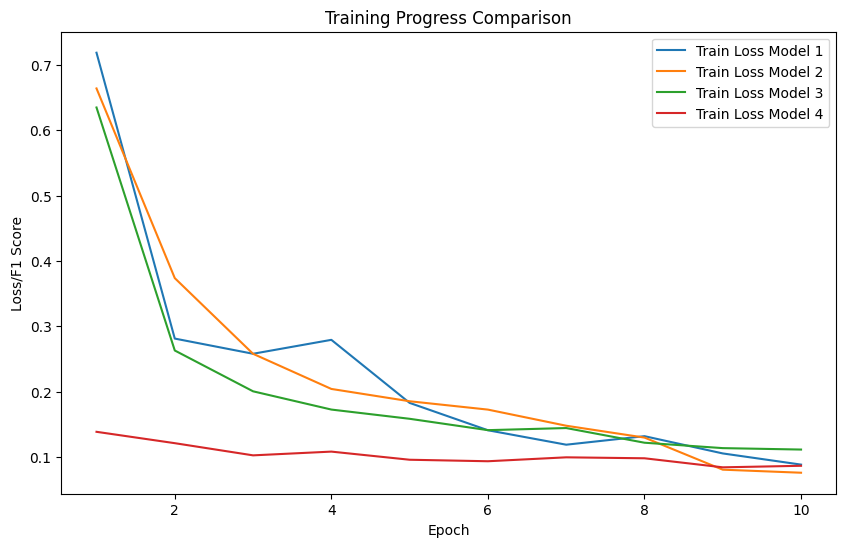

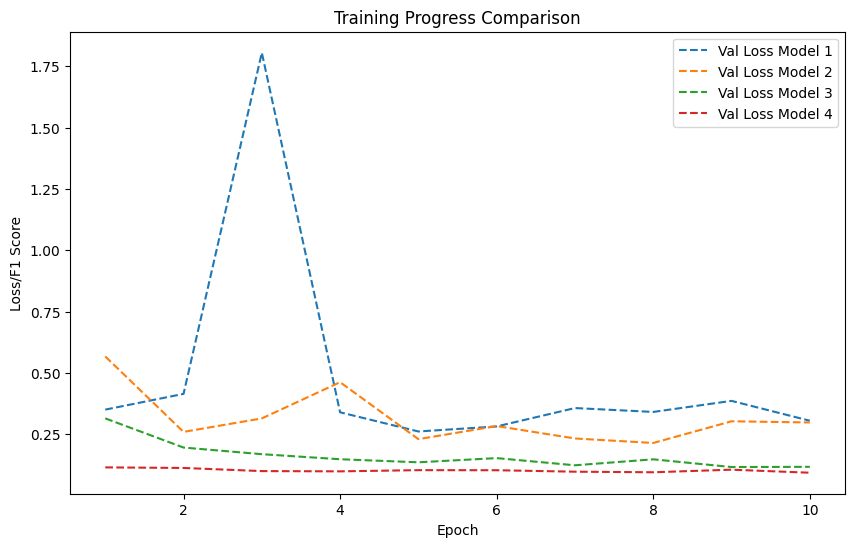

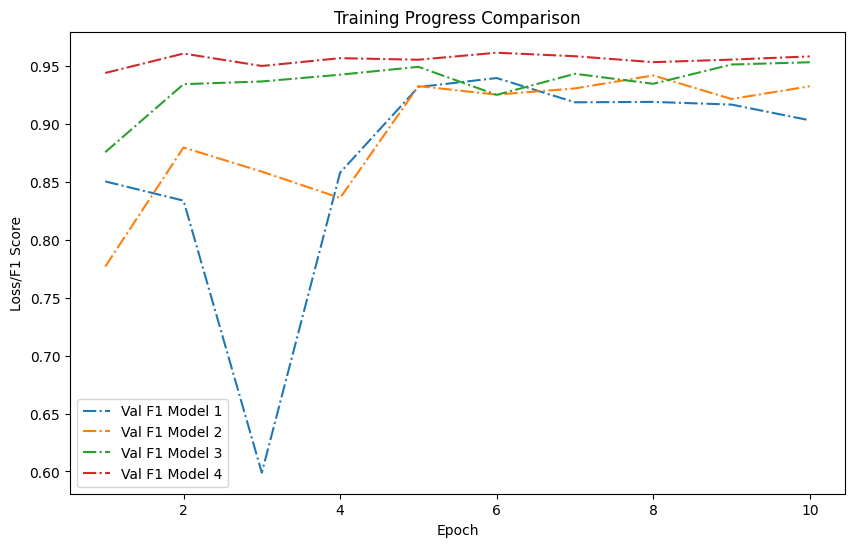

In [ ]:
# Paths to the CSV files
files = [
    '/content/drive/MyDrive/DLdata2/models_data/cnn_v3_train_val_losses.csv',
    '/content/drive/MyDrive/DLdata2/models_data/cnn_v2_train_val_losses.csv',
    '/content/drive/MyDrive/DLdata2/models_data/resnet50_v1_losses.csv',
    '/content/drive/MyDrive/DLdata2/models_data/resnet_v1_losses.csv'
]

labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Load and prepare the data
all_data = []
for file, label in zip(files, labels):
    df = pd.read_csv(file)
    df['Model'] = label
    all_data.append(df)

# Concatenate all data into a single DataFrame
combined_data = pd.concat(all_data)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training losses
for label in labels:
    subset = combined_data[combined_data['Model'] == label]
    ax.plot(subset['Epoch'], subset['Train Loss'], label=f'Train Loss {label}')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/F1 Score')
ax.set_title('Training Progress Comparison')
ax.legend()
plt.show()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot validation losses
for label in labels:
    subset = combined_data[combined_data['Model'] == label]
    ax.plot(subset['Epoch'], subset['Validation Loss'], linestyle='--', label=f'Val Loss {label}')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/F1 Score')
ax.set_title('Training Progress Comparison')
ax.legend()
plt.show()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot F1 Scores
for label in labels:
    subset = combined_data[combined_data['Model'] == label]
    ax.plot(subset['Epoch'], subset['Validation F1'], linestyle='-.', label=f'Val F1 {label}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/F1 Score')
ax.set_title('Training Progress Comparison')
ax.legend()
plt.show()

## Experiment 4.1: ViT Model - Version 1
* out of 12 encoder blocks, unfreeze the last 2 encoder blocks that are closer to the classification head
* run for 20 epochs with early stopping if validation f1 score lowers for 3 epochs
* batch_size = 256

### Load Preprocessed Dataset

In [ ]:
# Load the numpy files - size 224x224 for ViT
train_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_data_resized_224.npy')
train_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_labels.npy')
val_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_data_resized_224.npy')
val_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_labels.npy')

# Convert numpy arrays to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
val_dataset = TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_labels))

# Define data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Calculate class weights:

In [ ]:
# Calculate class frequencies
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Calculate total number of samples
total_samples = len(train_labels)

# Calculate class weights using the provided formula
class_weights_dict = {cls: 1 - (count / total_samples) for cls, count in zip(unique_classes, class_counts)}
class_weights = list(class_weights_dict.values())

print("Class weights:", class_weights)

Class weights: [0.8668397626112759, 0.6906528189910979, 0.7440652818991098, 0.6984421364985163]


**Unfreezing Strategy**
* Keep the bottom layers of the encoder frozen since they capture low-level features like edges and textures that are generally common across different types of images.
* Unfreeze the top layers of the encoder to allow the model to adapt and learn more high-level features specific to your task.

In [ ]:
# Load the pre-trained ViT-B/16 model
model = models.vit_b_16(pretrained=True)

# Check if the model has a classifier head named 'head' and if it is an instance of nn.Linear
if hasattr(model.heads, "head") and isinstance(model.heads.head, nn.Linear):
    # Replace the classifier head with a new one for the desired number of classes
    num_classes = 4  # Number of classes
    model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Freeze all parameters except the classification head
for name, param in model.named_parameters():
    if "head" not in name:  # Exclude parameters of the classification head
        param.requires_grad = False

# Unfreeze top layers of the encoder
num_encoder_layers = 12
# for i in range(8, num_encoder_layers):
for i in range(10, num_encoder_layers):
    for param in model.encoder.layers[i].parameters():
        param.requires_grad = True

# Verify the freezing status of the parameters
for name, param in model.named_parameters():
    print(name, param.requires_grad)

# Create a dummy input tensor and move it to the same device
dummy_input = torch.zeros(1, 3, 224, 224)

# Print out model summary
summary(model, input_data=dummy_input)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


class_token False
conv_proj.weight False
conv_proj.bias False
encoder.pos_embedding False
encoder.layers.encoder_layer_0.ln_1.weight False
encoder.layers.encoder_layer_0.ln_1.bias False
encoder.layers.encoder_layer_0.self_attention.in_proj_weight False
encoder.layers.encoder_layer_0.self_attention.in_proj_bias False
encoder.layers.encoder_layer_0.self_attention.out_proj.weight False
encoder.layers.encoder_layer_0.self_attention.out_proj.bias False
encoder.layers.encoder_layer_0.ln_2.weight False
encoder.layers.encoder_layer_0.ln_2.bias False
encoder.layers.encoder_layer_0.mlp.0.weight False
encoder.layers.encoder_layer_0.mlp.0.bias False
encoder.layers.encoder_layer_0.mlp.3.weight False
encoder.layers.encoder_layer_0.mlp.3.bias False
encoder.layers.encoder_layer_1.ln_1.weight False
encoder.layers.encoder_layer_1.ln_1.bias False
encoder.layers.encoder_layer_1.self_attention.in_proj_weight False
encoder.layers.encoder_layer_1.self_attention.in_proj_bias False
encoder.layers.encoder_layer

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 4]                    768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))  # Only optimize unfrozen parameters

# Define early stopping parameters
patience = 3
best_val_f1 = 0.0
counter = 0

# Initialize dictionary to store epoch results
epoch_results = {
    'Epoch': [],
    'Train Loss': [],
    'Train F1 Score': [],
    'Val Loss': [],
    'Val F1 Score': []
}

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_predictions = []
    train_targets = []
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for data, labels in progress_bar:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_targets.extend(labels.tolist())
        progress_bar.set_postfix({'Loss': train_loss / len(progress_bar)})

    # Calculate train f1_score and loss
    train_loss /= len(train_loader)
    train_f1 = f1_score(train_targets, train_predictions, average='weighted')

    # Evaluate the model on validation set
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for data, labels in val_loader:
            outputs = model(data)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    # Calculate validation f1_score and loss
    val_loss /= len(val_loader)
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')

    # Add epoch results to the dictionary
    epoch_results['Epoch'].append(epoch + 1)
    epoch_results['Train Loss'].append(train_loss)
    epoch_results['Train F1 Score'].append(train_f1)
    epoch_results['Val Loss'].append(val_loss)
    epoch_results['Val F1 Score'].append(val_f1)

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1 Score: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1 Score: {val_f1:.4f}')

    # Check for improvement in validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Convert epoch results to DataFrame
epoch_df = pd.DataFrame(epoch_results)


Epoch 1/20, Train Loss: 0.6755, Train F1 Score: 0.7492, Val Loss: 0.2564, Val F1 Score: 0.8423


Epoch 2/20, Train Loss: 0.1590, Train F1 Score: 0.9295, Val Loss: 0.0941, Val F1 Score: 0.9668


Epoch 3/20, Train Loss: 0.0830, Train F1 Score: 0.9759, Val Loss: 0.0897, Val F1 Score: 0.9693


Epoch 4/20, Train Loss: 0.0467, Train F1 Score: 0.9881, Val Loss: 0.0803, Val F1 Score: 0.9740


Epoch 5/20, Train Loss: 0.0263, Train F1 Score: 0.9918, Val Loss: 0.1165, Val F1 Score: 0.9774


Epoch 6/20, Train Loss: 0.0116, Train F1 Score: 0.9963, Val Loss: 0.1073, Val F1 Score: 0.9676


Epoch 7/20, Train Loss: 0.0102, Train F1 Score: 0.9967, Val Loss: 0.1217, Val F1 Score: 0.9709


Epoch 8/20, Train Loss: 0.0071, Train F1 Score: 0.9967, Val Loss: 0.0990, Val F1 Score: 0.9689
Early stopping at epoch 8


In [ ]:
# Save the model architecture and weights
output_path_vit_v1_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v1/'
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': model
}, output_path_vit_v1_base + 'vit_v1_model.pth')

 # Save optimizer state - in case we want to resume training from where we left off, including continuing the optimization process with the same optimizer settings
torch.save(optimizer.state_dict(), output_path_vit_v1_base + 'vit_v1_optimizer.pth')


In [ ]:
# Save the model results to a csv
epoch_df.to_csv(output_path_vit_v1_base+'epoch_results.csv')

epoch_df

Epoch  Train Loss  Train F1 Score  Val Loss  Val F1 Score
0      1    0.675521        0.749173  0.256384      0.842288
1      2    0.158968        0.929525  0.094125      0.966755
2      3    0.083050        0.975883  0.089735      0.969266
3      4    0.046718        0.988118  0.080304      0.974008
4      5    0.026301        0.991846  0.116483      0.977399
5      6    0.011619        0.996297  0.107251      0.967556
6      7    0.010172        0.996666  0.121700      0.970857
7      8    0.007090        0.996662  0.099014      0.968865

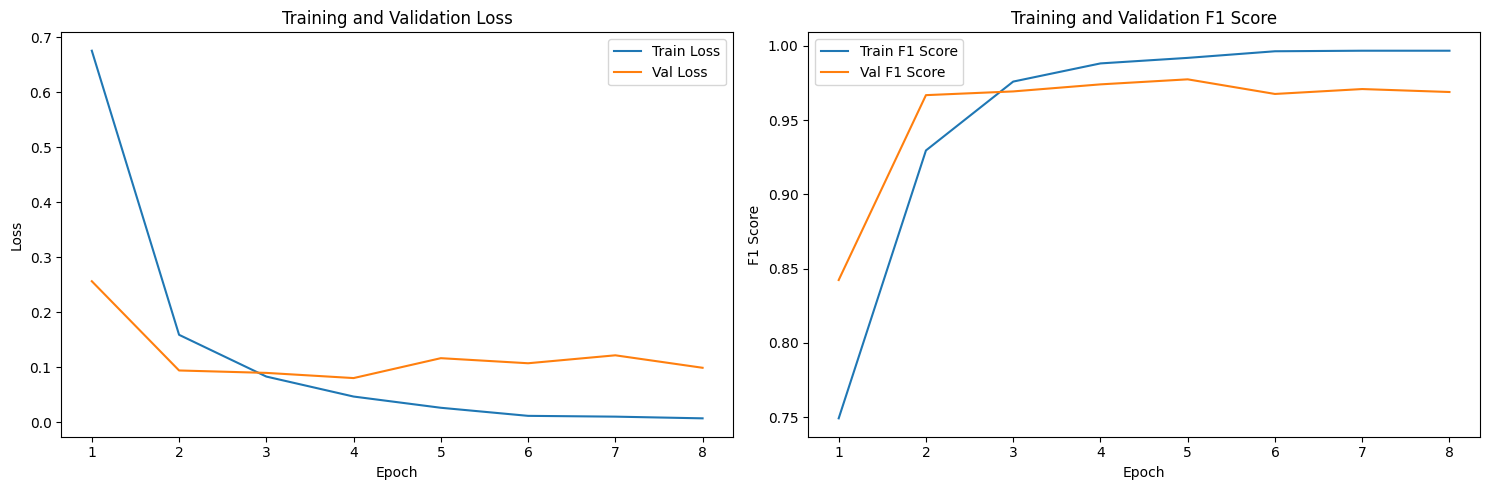

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss curves
axs[0].plot(epoch_df['Epoch'], epoch_df['Train Loss'], label='Train Loss')
axs[0].plot(epoch_df['Epoch'], epoch_df['Val Loss'], label='Val Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation F1 score curves
axs[1].plot(epoch_df['Epoch'], epoch_df['Train F1 Score'], label='Train F1 Score')
axs[1].plot(epoch_df['Epoch'], epoch_df['Val F1 Score'], label='Val F1 Score')
axs[1].set_title('Training and Validation F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('F1 Score')
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Test loading the model and evaluating it on validation set
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import f1_score

# Define the model architecture
loaded_model = models.vit_b_16(pretrained=False)
num_classes = 4  # Number of classes
loaded_model.heads.head = nn.Linear(loaded_model.heads.head.in_features, num_classes)

output_path_vit_v1_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v1/'

# Load the model and its state dictionary
checkpoint = torch.load(output_path_vit_v1_base + 'vit_v1_model.pth')
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

# Evaluate the model on the validation set
loaded_model.eval()
val_predictions = []
val_targets = []
val_loss = 0.0
with torch.no_grad():
    for data, labels in val_loader:
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.tolist())
        val_targets.extend(labels.tolist())

# Calculate validation loss and F1 score
val_loss /= len(val_loader)
val_f1 = f1_score(val_targets, val_predictions, average='weighted')

print(f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}')

# Save val_predictions and val_targets to a .npy file
np.save(output_path_vit_v1_base + 'vit_v1_val_predictions.npy', np.array(val_predictions))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Validation Loss: 0.0990, Validation F1 Score: 0.9689


## ViT Model - Version 2
* out of 12 encoder blocks, unfreeze the last 1 encoder block that is closer to the classification head
* run for 20 epochs with early stopping if validation f1 score lowers for 2 epochs
* batch_size = 64
* added regularization
  * L2 regularization: weight_decay=1e-4
  * Dropout=0.2 (only applies to unfrozen parameters)

In [ ]:
# Load the pre-trained ViT-B/16 model
model = models.vit_b_16(pretrained=True)

# Check if the model has a classifier head named 'head' and if it is an instance of nn.Linear
if hasattr(model.heads, "head") and isinstance(model.heads.head, nn.Linear):
    # Replace the classifier head with a new one for the desired number of classes
    num_classes = 4  # Number of classes
    model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Freeze all parameters except the classification head
for name, param in model.named_parameters():
    if "head" not in name:  # Exclude parameters of the classification head
        param.requires_grad = False

# Unfreeze top layers of the encoder
num_encoder_layers = 12
for i in range(11, num_encoder_layers):
    for param in model.encoder.layers[i].parameters():
        param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

# Add weight decay regularization to the optimizer
weight_decay = 1e-4
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), # only optimize the trainabile parameters
    weight_decay=weight_decay # L2 regularization
)

# Define the dropout rate
dropout_rate = 0.2

# Add dropout layers to the unfrozen layers for regularization
for i in range(11, num_encoder_layers):
    # Insert dropout after the activation function in each layer
    model.encoder.layers[i].dropout = nn.Dropout(dropout_rate)

# Verify the freezing status of the parameters
for name, param in model.named_parameters():
    print(name, param.requires_grad)

# Create a dummy input tensor and move it to the same device
dummy_input = torch.zeros(1, 3, 224, 224)

# Print out model summary
summary(model, input_data=dummy_input)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


class_token False
conv_proj.weight False
conv_proj.bias False
encoder.pos_embedding False
encoder.layers.encoder_layer_0.ln_1.weight False
encoder.layers.encoder_layer_0.ln_1.bias False
encoder.layers.encoder_layer_0.self_attention.in_proj_weight False
encoder.layers.encoder_layer_0.self_attention.in_proj_bias False
encoder.layers.encoder_layer_0.self_attention.out_proj.weight False
encoder.layers.encoder_layer_0.self_attention.out_proj.bias False
encoder.layers.encoder_layer_0.ln_2.weight False
encoder.layers.encoder_layer_0.ln_2.bias False
encoder.layers.encoder_layer_0.mlp.0.weight False
encoder.layers.encoder_layer_0.mlp.0.bias False
encoder.layers.encoder_layer_0.mlp.3.weight False
encoder.layers.encoder_layer_0.mlp.3.bias False
encoder.layers.encoder_layer_1.ln_1.weight False
encoder.layers.encoder_layer_1.ln_1.bias False
encoder.layers.encoder_layer_1.self_attention.in_proj_weight False
encoder.layers.encoder_layer_1.self_attention.in_proj_bias False
encoder.layers.encoder_layer

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 4]                    768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [ ]:
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
output_path_vit_v2_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v2_best/'

# Define early stopping parameters
patience = 2
best_val_f1 = 0.0
counter = 0

# Initialize dictionary to store epoch results
epoch_results = {
    'Epoch': [],
    'Train Loss': [],
    'Train F1 Score': [],
    'Val Loss': [],
    'Val F1 Score': []
}

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_predictions = []
    train_targets = []
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for data, labels in progress_bar:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_targets.extend(labels.tolist())
        progress_bar.set_postfix({'Loss': train_loss / len(progress_bar)})

    # Calculate train f1_score and loss
    train_loss /= len(train_loader)
    train_f1 = f1_score(train_targets, train_predictions, average='weighted')

    # Evaluate the model on validation set
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for data, labels in val_loader:
            outputs = model(data)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    # Calculate validation f1_score and loss
    val_loss /= len(val_loader)
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')

    # Add epoch results to the dictionary
    epoch_results['Epoch'].append(epoch + 1)
    epoch_results['Train Loss'].append(train_loss)
    epoch_results['Train F1 Score'].append(train_f1)
    epoch_results['Val Loss'].append(val_loss)
    epoch_results['Val F1 Score'].append(val_f1)

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1 Score: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1 Score: {val_f1:.4f}')

    # Check for improvement in validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        counter = 0
        # Save the best model
        print('Saving best model so far...')
        # Save the best model architecture and weights
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_architecture': model
        }, output_path_vit_v2_base + 'vit_v2_model.pth')

        # Save the best optimizer state - in case we want to resume training from where we left off, including continuing the optimization process with the same optimizer settings
        torch.save(optimizer.state_dict(), output_path_vit_v2_base + 'vit_v2_optimizer.pth')

    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Convert epoch results to DataFrame
epoch_df = pd.DataFrame(epoch_results)


Epoch 1/20, Train Loss: 0.2978, Train F1 Score: 0.8841, Val Loss: 0.1454, Val F1 Score: 0.9403
Saving best model so far...


Epoch 2/20, Train Loss: 0.0884, Train F1 Score: 0.9711, Val Loss: 0.1047, Val F1 Score: 0.9702
Saving best model so far...


Epoch 3/20, Train Loss: 0.0468, Train F1 Score: 0.9851, Val Loss: 0.0681, Val F1 Score: 0.9723
Saving best model so far...


Epoch 4/20, Train Loss: 0.0240, Train F1 Score: 0.9930, Val Loss: 0.0893, Val F1 Score: 0.9724
Saving best model so far...


Epoch 5/20, Train Loss: 0.0104, Train F1 Score: 0.9967, Val Loss: 0.0999, Val F1 Score: 0.9759
Saving best model so far...


Epoch 6/20, Train Loss: 0.0065, Train F1 Score: 0.9978, Val Loss: 0.1129, Val F1 Score: 0.9725


Epoch 7/20, Train Loss: 0.0326, Train F1 Score: 0.9885, Val Loss: 0.2771, Val F1 Score: 0.9277
Early stopping at epoch 7


In [ ]:
# Save the model results to a csv
epoch_df.to_csv(output_path_vit_v2_base+'epoch_results.csv')
epoch_df

Epoch  Train Loss  Train F1 Score  Val Loss  Val F1 Score
0      1    0.297815        0.884056  0.145354      0.940315
1      2    0.088438        0.971115  0.104732      0.970230
2      3    0.046800        0.985142  0.068117      0.972318
3      4    0.023987        0.992960  0.089301      0.972379
4      5    0.010365        0.996661  0.099851      0.975882
5      6    0.006498        0.997776  0.112888      0.972550
6      7    0.032595        0.988516  0.277141      0.927712

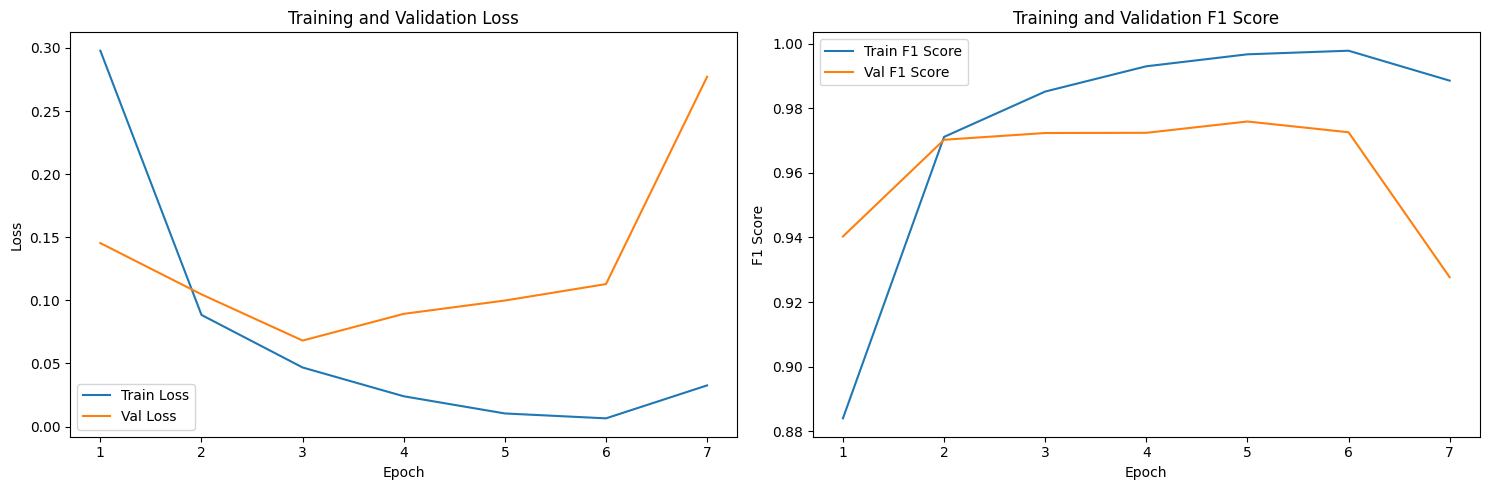

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss curves
axs[0].plot(epoch_df['Epoch'], epoch_df['Train Loss'], label='Train Loss')
axs[0].plot(epoch_df['Epoch'], epoch_df['Val Loss'], label='Val Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation F1 score curves
axs[1].plot(epoch_df['Epoch'], epoch_df['Train F1 Score'], label='Train F1 Score')
axs[1].plot(epoch_df['Epoch'], epoch_df['Val F1 Score'], label='Val F1 Score')
axs[1].set_title('Training and Validation F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('F1 Score')
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Test loading the model and evaluating it on validation set

# Define the model architecture
loaded_model = models.vit_b_16(pretrained=False)
num_classes = 4  # Number of classes
loaded_model.heads.head = nn.Linear(loaded_model.heads.head.in_features, num_classes)

output_path_vit_v2_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v2_best/'

# Load the model and its state dictionary
checkpoint = torch.load(output_path_vit_v2_base + 'vit_v2_model.pth')
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

# Evaluate the model on the validation set
loaded_model.eval()
val_predictions = []
val_targets = []
val_loss = 0.0
with torch.no_grad():
    for data, labels in val_loader:
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.tolist())
        val_targets.extend(labels.tolist())

# Calculate validation loss and F1 score
val_loss /= len(val_loader)
val_f1 = f1_score(val_targets, val_predictions, average='weighted')

print(f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}')

# Save val_predictions and val_targets to a .npy file
np.save(output_path_vit_v2_base + 'vit_v2_val_predictions.npy', np.array(val_predictions))

Validation Loss: 0.2771, Validation F1 Score: 0.9277


## ViT Model - Version 3
* out of 12 encoder blocks, unfreeze the last 1 encoder block that is closer to the classification head
* run for 20 epochs with early stopping if validation loss increases for 4 epochs
* batch_size = 64
* added regularization
  * L2 regularization: weight_decay=1e-4
  * Dropout=0.2 (only applies to unfrozen parameters)
* Adding even more regularization (weight_decay=1e-3, dropout=0.4)
* Added learning rate scheduler based on val performance plateau-ing, learning rate reduces by 50% when validation loss increases for 2 epochs
* Modified early stopping to be based on val_loss instead of val_f1

In [ ]:
# Load the pre-trained ViT-B/16 model
model = models.vit_b_16(pretrained=True)

# Check if the model has a classifier head named 'head' and if it is an instance of nn.Linear
if hasattr(model.heads, "head") and isinstance(model.heads.head, nn.Linear):
    # Replace the classifier head with a new one for the desired number of classes
    num_classes = 4  # Number of classes
    model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Freeze all parameters except the classification head
for name, param in model.named_parameters():
    if "head" not in name:  # Exclude parameters of the classification head
        param.requires_grad = False

# Unfreeze top layers of the encoder
num_encoder_layers = 12
for i in range(11, num_encoder_layers):
    for param in model.encoder.layers[i].parameters():
        param.requires_grad = True

# Define loss function
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

# Define the optimizer
weight_decay = 1e-3
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    weight_decay=weight_decay
)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Define the dropout rate
dropout_rate = 0.4

# Add dropout layers to the unfrozen layers for regularization
for i in range(11, num_encoder_layers):
    # Insert dropout after the activation function in each layer
    model.encoder.layers[i].dropout = nn.Dropout(dropout_rate)

# Verify the freezing status of the parameters
for name, param in model.named_parameters():
    print(name, param.requires_grad)

# Create a dummy input tensor and move it to the same device
dummy_input = torch.zeros(1, 3, 224, 224)

# Print out model summary
summary(model, input_data=dummy_input)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


class_token False
conv_proj.weight False
conv_proj.bias False
encoder.pos_embedding False
encoder.layers.encoder_layer_0.ln_1.weight False
encoder.layers.encoder_layer_0.ln_1.bias False
encoder.layers.encoder_layer_0.self_attention.in_proj_weight False
encoder.layers.encoder_layer_0.self_attention.in_proj_bias False
encoder.layers.encoder_layer_0.self_attention.out_proj.weight False
encoder.layers.encoder_layer_0.self_attention.out_proj.bias False
encoder.layers.encoder_layer_0.ln_2.weight False
encoder.layers.encoder_layer_0.ln_2.bias False
encoder.layers.encoder_layer_0.mlp.0.weight False
encoder.layers.encoder_layer_0.mlp.0.bias False
encoder.layers.encoder_layer_0.mlp.3.weight False
encoder.layers.encoder_layer_0.mlp.3.bias False
encoder.layers.encoder_layer_1.ln_1.weight False
encoder.layers.encoder_layer_1.ln_1.bias False
encoder.layers.encoder_layer_1.self_attention.in_proj_weight False
encoder.layers.encoder_layer_1.self_attention.in_proj_bias False
encoder.layers.encoder_layer

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 4]                    768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [ ]:
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import time
import datetime
import pytz

output_path_vit_v3_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v3_best/'

# Define early stopping parameters
patience = 4
best_val_loss = float('inf')  # Initialize with a very large value for the best validation loss
counter = 0

# Initialize dictionary to store epoch results
epoch_results = {
    'Epoch': [],
    'Train Loss': [],
    'Val Loss': [],
    'Train F1 Score': [],
    'Val F1 Score': []
}

# Start the timer
start_time = time.time()
start_time_pacific = datetime.datetime.now(pytz.timezone('US/Pacific'))
print("Start time (Pacific Time):", start_time_pacific.strftime('%Y-%m-%d %I:%M:%S %p %Z'))

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_predictions = []
    train_targets = []
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for data, labels in progress_bar:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_targets.extend(labels.tolist())
        progress_bar.set_postfix({'Loss': train_loss / len(progress_bar)})

    # Calculate train loss
    train_loss /= len(train_loader)

    # Calculate train F1 score
    train_f1 = f1_score(train_targets, train_predictions, average='weighted')

    # Evaluate the model on validation set
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for data, labels in val_loader:
            outputs = model(data)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    # Calculate validation loss
    val_loss /= len(val_loader)

    # Calculate validation F1 score
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')

    # Add epoch results to the dictionary
    epoch_results['Epoch'].append(epoch + 1)
    epoch_results['Train Loss'].append(train_loss)
    epoch_results['Val Loss'].append(val_loss)
    epoch_results['Train F1 Score'].append(train_f1)
    epoch_results['Val F1 Score'].append(val_f1)

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1 Score: {train_f1:.4f}, Val F1 Score: {val_f1:.4f}')

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Print the learning rate
    print("Learning rate is now: ", scheduler.get_last_lr()[0])

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print('Saving best model so far...')
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_architecture': model
        }, output_path_vit_v3_base + 'vit_v3_model.pth')

        # Save the best optimizer state
        torch.save(optimizer.state_dict(), output_path_vit_v3_base + 'vit_v3_optimizer.pth')

# Convert epoch results to DataFrame
epoch_df = pd.DataFrame(epoch_results)

# End the timer
end_time = time.time()
end_time_pacific = datetime.datetime.now(pytz.timezone('US/Pacific'))
print("End time (Pacific Time):", end_time_pacific.strftime('%Y-%m-%d %I:%M:%S %p %Z'))

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Elapsed time: {hours} hours, {minutes} minutes, {seconds} seconds")


Start time (Pacific Time): 2024-05-10 01:55:07 AM PDT


Epoch 1/20, Train Loss: 0.3036, Val Loss: 0.1003, Train F1 Score: 0.8866, Val F1 Score: 0.9663
Learning rate is now:  0.001
Saving best model so far...


Epoch 2/20, Train Loss: 0.1125, Val Loss: 0.0757, Train F1 Score: 0.9607, Val F1 Score: 0.9741
Learning rate is now:  0.001
Saving best model so far...


Epoch 3/20, Train Loss: 0.0661, Val Loss: 0.0794, Train F1 Score: 0.9789, Val F1 Score: 0.9708
Learning rate is now:  0.001


Epoch 4/20, Train Loss: 0.0732, Val Loss: 0.1002, Train F1 Score: 0.9782, Val F1 Score: 0.9659
Learning rate is now:  0.001


Epoch 5/20, Train Loss: 0.0462, Val Loss: 0.1008, Train F1 Score: 0.9867, Val F1 Score: 0.9674
Learning rate is now:  0.0005


Epoch 6/20, Train Loss: 0.0421, Val Loss: 0.0945, Train F1 Score: 0.9848, Val F1 Score: 0.9725
Learning rate is now:  0.0005


Epoch 7/20, Train Loss: 0.0169, Val Loss: 0.0875, Train F1 Score: 0.9944, Val F1 Score: 0.9739
Learning rate is now:  0.0005


Epoch 8/20, Train Loss: 0.0144, Val Loss: 0.1174, Train F1 Score: 0.9948, Val F1 Score: 0.9641
Learning rate is now:  0.00025


Epoch 9/20, Train Loss: 0.0091, Val Loss: 0.0858, Train F1 Score: 0.9967, Val F1 Score: 0.9723
Learning rate is now:  0.00025


Epoch 10/20, Train Loss: 0.0043, Val Loss: 0.0960, Train F1 Score: 0.9993, Val F1 Score: 0.9668
Learning rate is now:  0.00025


Epoch 11/20, Train Loss: 0.0045, Val Loss: 0.0954, Train F1 Score: 0.9989, Val F1 Score: 0.9740
Learning rate is now:  0.000125


KeyboardInterrupt: 

In [ ]:
# Convert epoch results to DataFrame
epoch_df = pd.DataFrame(epoch_results)

# End the timer
end_time = time.time()
end_time_pacific = datetime.datetime.now(pytz.timezone('US/Pacific'))
print("End time (Pacific Time):", end_time_pacific.strftime('%Y-%m-%d %I:%M:%S %p %Z'))

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Elapsed time: {hours} hours, {minutes} minutes, {seconds} seconds")


End time (Pacific Time): 2024-05-10 03:31:59 AM PDT
Elapsed time: 1 hours, 36 minutes, 51 seconds


In [ ]:
# Save the model results to a csv
epoch_df.to_csv(output_path_vit_v3_base+'epoch_results.csv')

epoch_df

Epoch  Train Loss  Val Loss  Train F1 Score  Val F1 Score
0       1    0.303590  0.100317        0.886648      0.966350
1       2    0.112530  0.075734        0.960723      0.974072
2       3    0.066136  0.079373        0.978858      0.970810
3       4    0.073185  0.100169        0.978174      0.965912
4       5    0.046208  0.100809        0.986665      0.967450
5       6    0.042109  0.094501        0.984807      0.972549
6       7    0.016935  0.087498        0.994440      0.973940
7       8    0.014388  0.117433        0.994807      0.964057
8       9    0.009099  0.085810        0.996665      0.972253
9      10    0.004278  0.095969        0.999258      0.966810
10     11    0.004530  0.095437        0.998888      0.974031

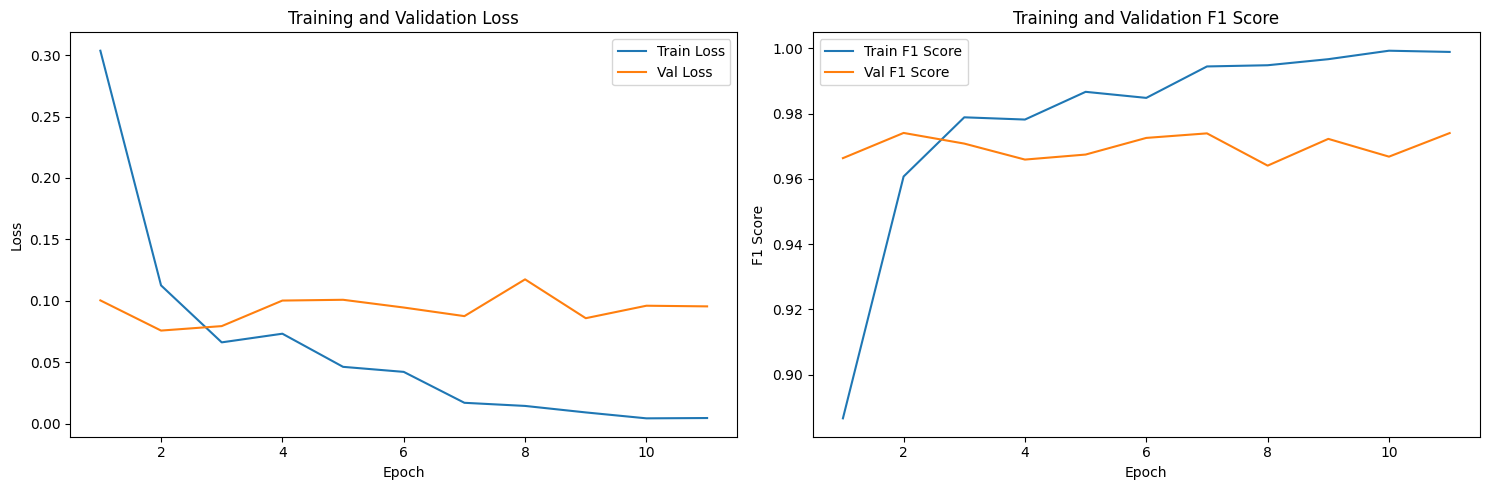

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss curves
axs[0].plot(epoch_df['Epoch'], epoch_df['Train Loss'], label='Train Loss')
axs[0].plot(epoch_df['Epoch'], epoch_df['Val Loss'], label='Val Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation F1 score curves
axs[1].plot(epoch_df['Epoch'], epoch_df['Train F1 Score'], label='Train F1 Score')
axs[1].plot(epoch_df['Epoch'], epoch_df['Val F1 Score'], label='Val F1 Score')
axs[1].set_title('Training and Validation F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('F1 Score')
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Test loading the model and evaluating it on validation set

# Start the timer
start_time = time.time()
start_time_pacific = datetime.datetime.now(pytz.timezone('US/Pacific'))
print("Start time (Pacific Time):", start_time_pacific.strftime('%Y-%m-%d %I:%M:%S %p %Z'))

# Define the model architecture
loaded_model = models.vit_b_16(pretrained=False)
num_classes = 4  # Number of classes
loaded_model.heads.head = nn.Linear(loaded_model.heads.head.in_features, num_classes)

output_path_vit_v3_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v3_best/'

# Load the model and its state dictionary
checkpoint = torch.load(output_path_vit_v3_base + 'vit_v3_model.pth')
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

# Evaluate the model on the validation set
loaded_model.eval()
val_predictions = []
val_targets = []
val_loss = 0.0
with torch.no_grad():
    for data, labels in val_loader:
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.tolist())
        val_targets.extend(labels.tolist())

# Calculate validation loss and F1 score
val_loss /= len(val_loader)
val_f1 = f1_score(val_targets, val_predictions, average='weighted')

print(f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}')

# Save val_predictions and val_targets to a .npy file
np.save(output_path_vit_v3_base + 'vit_v3_val_predictions.npy', np.array(val_predictions))

# End the timer
end_time = time.time()
end_time_pacific = datetime.datetime.now(pytz.timezone('US/Pacific'))
print("End time (Pacific Time):", end_time_pacific.strftime('%Y-%m-%d %I:%M:%S %p %Z'))

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Elapsed time: {hours} hours, {minutes} minutes, {seconds} seconds")

Start time (Pacific Time): 2024-05-10 03:32:22 AM PDT


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Validation Loss: 0.0901, Validation F1 Score: 0.9703
End time (Pacific Time): 2024-05-10 03:33:44 AM PDT
Elapsed time: 0 hours, 1 minutes, 22 seconds


# Final ViT Model Results
We selected ViT Model 1 to be the best ViT model because it had the smoothest train/val loss/f1 score curves, indicating better training stability. Let's retrive and visualize the results for this model.

In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

### Load the data

In [ ]:
# Load the numpy files - size 224x224 for ViT
train_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_data_resized_224.npy')
train_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/train_labels.npy')
val_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_data_resized_224.npy')
val_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/val_labels.npy')
test_data = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/test_data_resized_224.npy')
test_labels = np.load('/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/preprocessed_data/color_corn_224/test_labels.npy')

# Convert numpy arrays to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
val_dataset = TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_labels))
test_dataset = TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))

# Define data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Load model training dataframe and plot train/val loss/f1 score curves

In [ ]:
output_path_vit_v1_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v1/'
# Load the model results from saved csv
epoch_df = pd.read_csv(output_path_vit_v1_base+'epoch_results.csv')
epoch_df.drop(columns=['Unnamed: 0'], inplace=True)
epoch_df

Epoch  Train Loss  Train F1 Score  Val Loss  Val F1 Score
0      1    0.675521        0.749173  0.256384      0.842288
1      2    0.158968        0.929525  0.094125      0.966755
2      3    0.083050        0.975883  0.089735      0.969266
3      4    0.046718        0.988118  0.080304      0.974008
4      5    0.026301        0.991846  0.116483      0.977399
5      6    0.011619        0.996297  0.107251      0.967556
6      7    0.010172        0.996666  0.121700      0.970857
7      8    0.007090        0.996662  0.099014      0.968865

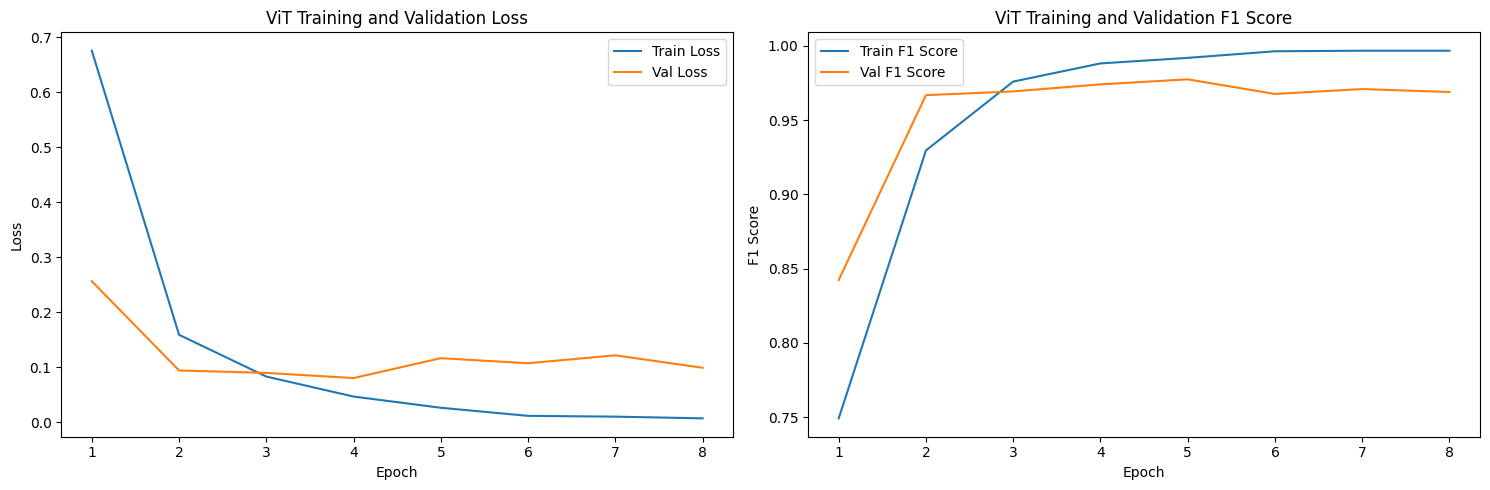

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss curves
axs[0].plot(epoch_df['Epoch'], epoch_df['Train Loss'], label='Train Loss')
axs[0].plot(epoch_df['Epoch'], epoch_df['Val Loss'], label='Val Loss')
axs[0].set_title('ViT Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation F1 score curves
axs[1].plot(epoch_df['Epoch'], epoch_df['Train F1 Score'], label='Train F1 Score')
axs[1].plot(epoch_df['Epoch'], epoch_df['Val F1 Score'], label='Val F1 Score')
axs[1].set_title('ViT Training and Validation F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('F1 Score')
axs[1].legend()

plt.tight_layout()
plt.show()


### Load the model

In [ ]:
# Calculate class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
total_samples = len(train_labels)
class_weights_dict = {cls: 1 - (count / total_samples) for cls, count in zip(unique_classes, class_counts)}
class_weights = list(class_weights_dict.values())

# Define the model architecture
loaded_model = models.vit_b_16(pretrained=False)
num_classes = 4  # Number of classes
loaded_model.heads.head = nn.Linear(loaded_model.heads.head.in_features, num_classes)

output_path_vit_v1_base = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/model_results/vit_v1/'

# Load the model and its state dictionary
checkpoint = torch.load(output_path_vit_v1_base + 'vit_v1_model.pth')
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Evaluate the model on train

In [ ]:
# Evaluate the model on the train set
loaded_model.eval()
train_predictions = []
train_targets = []
train_loss = 0.0
with torch.no_grad():
    for data, labels in train_loader:
        outputs = loaded_model(data)
        loss = criterion(outputs, labels.long())
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_targets.extend(labels.tolist())

# Calculate train loss and F1 score
train_loss /= len(train_loader)
train_f1 = f1_score(train_targets, train_predictions, average='weighted')

print(f'Train Loss: {train_loss:.4f}, Train F1 Score: {train_f1:.4f}')

Train Loss: 0.0073, Train F1 Score: 0.9989


## Evaluate the model on val

In [ ]:
# Evaluate the model on the validation set
loaded_model.eval()
val_predictions = []
val_targets = []
val_loss = 0.0
with torch.no_grad():
    for data, labels in val_loader:
        outputs = loaded_model(data)
        loss = criterion(outputs, labels.long())
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.tolist())
        val_targets.extend(labels.tolist())

# Calculate validation loss and F1 score
val_loss /= len(val_loader)
val_f1 = f1_score(val_targets, val_predictions, average='weighted')

print(f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}')

Validation Loss: 0.0990, Validation F1 Score: 0.9689


In [ ]:
from sklearn.metrics import precision_score, recall_score

# Calculate val precision and recall
val_precision = precision_score(val_targets, val_predictions, average='weighted')
val_recall = recall_score(val_targets, val_predictions, average='weighted')

print(f'Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}')

Val Precision: 0.9689, Val Recall: 0.9689


### Print model classification report for val

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(val_targets, val_predictions))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        77
           1       0.99      1.00      0.99       179
           2       0.95      0.94      0.95       147
           3       1.00      0.99      1.00       175

    accuracy                           0.97       578
   macro avg       0.96      0.96      0.96       578
weighted avg       0.97      0.97      0.97       578



### Plot model confusion matrix for val

Define plotting function:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = ['Gray \n Leaf Spot', 'Common \n Rust', 'Northern \n Leaf Blight', 'Healthy']

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Plot non-normalized confusion matrix:

Confusion matrix, without normalization


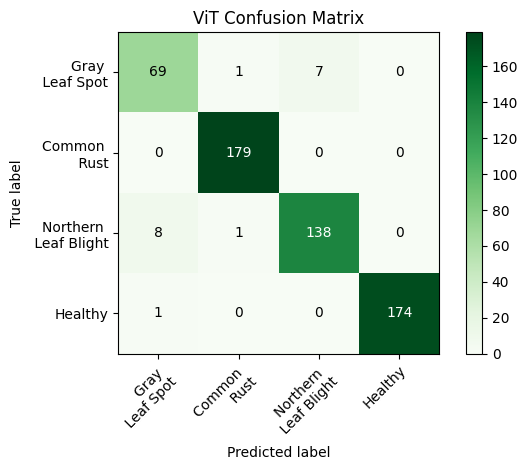

In [ ]:
plot_confusion_matrix(val_targets, val_predictions, classes=class_names, title='ViT Confusion Matrix')
plt.show()

Plot normalized confusion matrix:

Normalized confusion matrix


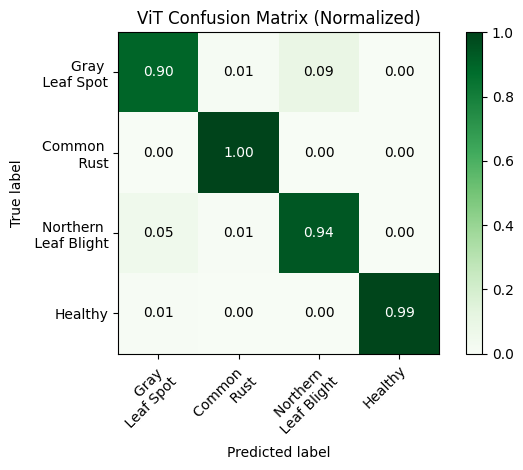

In [ ]:
plot_confusion_matrix(val_targets, val_predictions, classes=class_names, normalize=True, title='ViT Confusion Matrix (Normalized)')
plt.show()

### Display Misclassified Leaf Images for Val



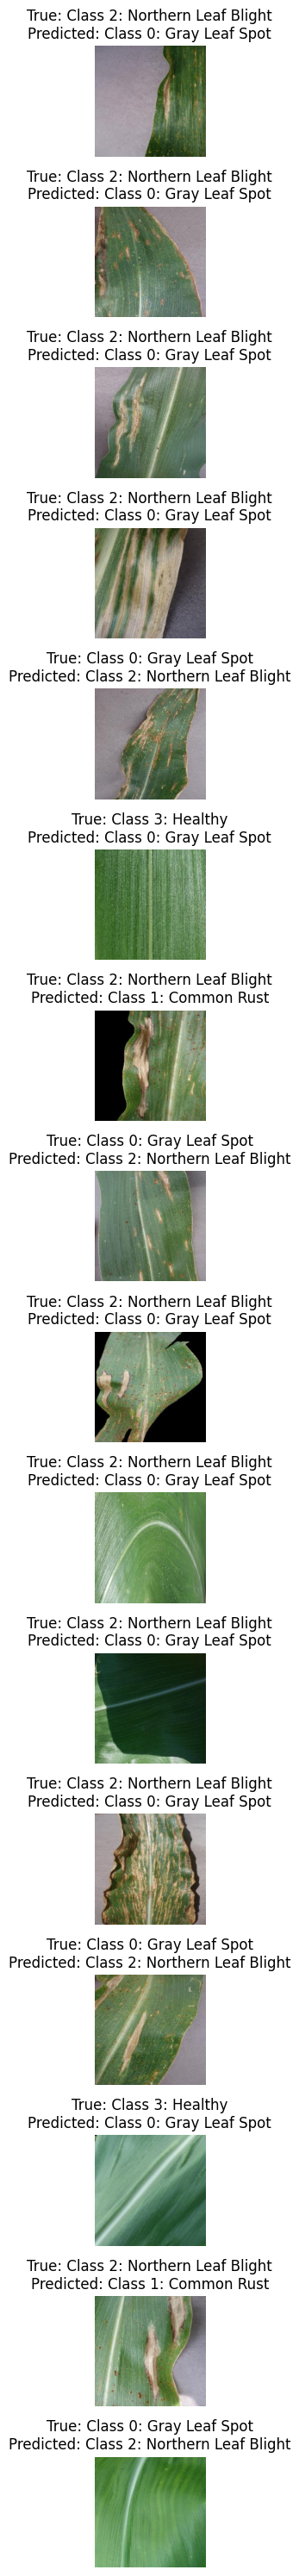

In [ ]:
class_names = {0: 'Class 0: Gray Leaf Spot',
               1: 'Class 1: Common Rust',
               2: 'Class 2: Northern Leaf Blight',
               3: 'Class 3: Healthy'}

import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, titles, figsize=(15, 30)):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 1, figsize=figsize)
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Define a function to plot misclassified images
def plot_misclassified_samples(val_predictions, val_targets, val_loader, class_names):
    misclassified_indices = np.where(np.array(val_predictions) != np.array(val_targets))[0]
    # num_misclassified = min(5, len(misclassified_indices)) # can also sample if # of misclassified is high
    # sample_indices = np.random.choice(misclassified_indices, num_misclassified, replace=False)
    sample_indices = misclassified_indices

    misclassified_images = []
    true_labels = []
    predicted_labels = []

    for batch_images, batch_labels in val_loader:
        for idx, label in enumerate(batch_labels):
            if idx in sample_indices:
                image = batch_images[idx].permute(1, 2, 0).numpy()  # Convert from tensor to numpy array
                misclassified_images.append(image)
                true_label = class_names[val_targets[idx]]
                predicted_label = class_names[val_predictions[idx]]
                true_labels.append(true_label)
                predicted_labels.append(predicted_label)

    plot_images(misclassified_images, [f'True: {true}\nPredicted: {pred}' for true, pred in zip(true_labels, predicted_labels)])

plot_misclassified_samples(val_predictions, val_targets, val_loader, class_names)



## Evaluate the model on test
Since we're selecting ViT as the final model, we'll evaluate it on test and display the plots for the test set.

In [ ]:
# Evaluate the model on the test set
loaded_model.eval()
test_predictions = []
test_targets = []
test_loss = 0.0
with torch.no_grad():
    for data, labels in test_loader:
        outputs = loaded_model(data)
        loss = criterion(outputs, labels.long())
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.tolist())
        test_targets.extend(labels.tolist())

# Calculate test loss and F1 score
test_loss /= len(test_loader)
test_f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Test Loss: {test_loss:.4f}, Test F1 Score: {test_f1:.4f}')

Test Loss: 0.0904, Test F1 Score: 0.9707


In [ ]:
from sklearn.metrics import precision_score, recall_score

# Calculate test precision and recall
test_precision = precision_score(test_targets, test_predictions, average='weighted')
test_recall = recall_score(test_targets, test_predictions, average='weighted')

print(f'Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}')

Test Precision: 0.9713, Test Recall: 0.9706


### Print model classification report for test

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_targets, test_predictions))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        77
           1       0.99      1.00      1.00       179
           2       0.96      0.93      0.94       148
           3       0.99      0.99      0.99       174

    accuracy                           0.97       578
   macro avg       0.96      0.96      0.96       578
weighted avg       0.97      0.97      0.97       578



### Plot model confusion matrix for test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = ['Gray \n Leaf Spot', 'Common \n Rust', 'Northern \n Leaf Blight', 'Healthy']

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Plot non-normalized confusion matrix:

Confusion matrix, without normalization


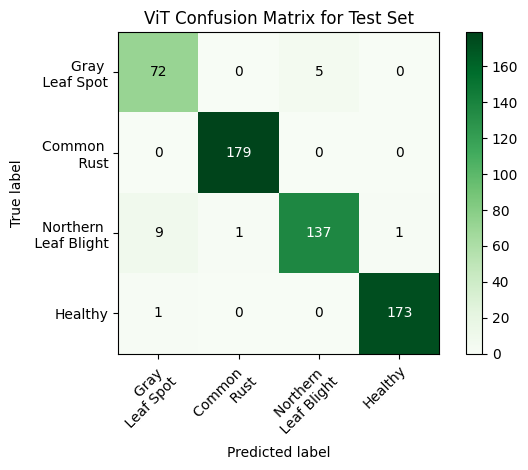

In [ ]:
plot_confusion_matrix(test_targets, test_predictions, classes=class_names, title='ViT Confusion Matrix for Test Set')
# plt.savefig('vit_confusion_matrix.png', transparent=True)
plt.show()

Plot normalized confusion matrix:

Normalized confusion matrix


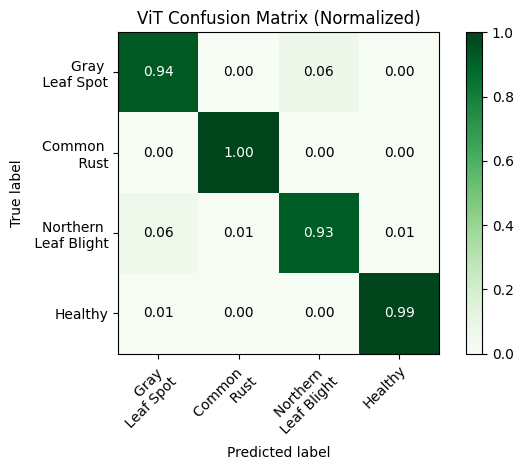

In [ ]:
plot_confusion_matrix(test_targets, test_predictions, classes=class_names, normalize=True, title='ViT Confusion Matrix (Normalized)')
plt.savefig('vit_confusion_matrix_normalized.png', transparent=True)
plt.show()

### Display Misclassified Leaf Images for Test



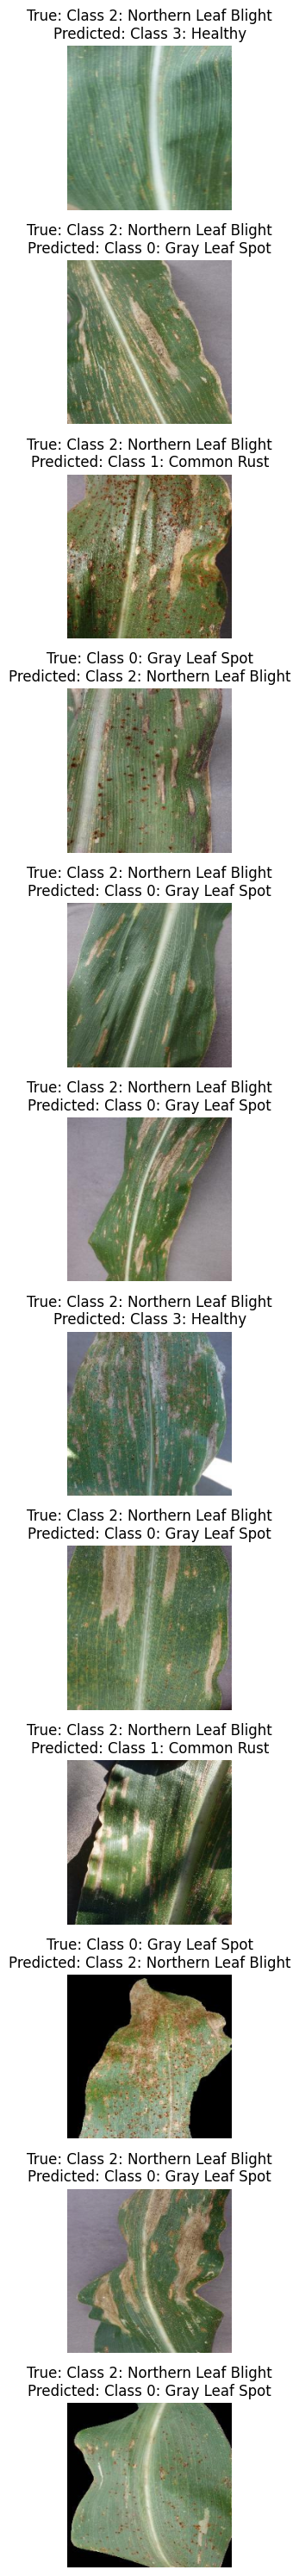

In [ ]:
class_names = {0: 'Class 0: Gray Leaf Spot',
               1: 'Class 1: Common Rust',
               2: 'Class 2: Northern Leaf Blight',
               3: 'Class 3: Healthy'}

import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, titles, figsize=(15, 30)):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 1, figsize=figsize)
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.tight_layout()
    # plt.savefig('misclassified_test.png', transparent=True)
    plt.show()

# Define a function to plot misclassified images
def plot_misclassified_samples(test_predictions, test_targets, test_loader, class_names):
    misclassified_indices = np.where(np.array(test_predictions) != np.array(test_targets))[0]
    # num_misclassified = min(5, len(misclassified_indices)) # can also sample if # of misclassified is high
    # sample_indices = np.random.choice(misclassified_indices, num_misclassified, replace=False)
    sample_indices = misclassified_indices

    misclassified_images = []
    true_labels = []
    predicted_labels = []

    for batch_images, batch_labels in test_loader:
        for idx, label in enumerate(batch_labels):
            if idx in sample_indices:
                image = batch_images[idx].permute(1, 2, 0).numpy()  # Convert from tensor to numpy array
                misclassified_images.append(image)
                true_label = class_names[test_targets[idx]]
                predicted_label = class_names[test_predictions[idx]]
                true_labels.append(true_label)
                predicted_labels.append(predicted_label)

    plot_images(misclassified_images, [f'True: {true}\nPredicted: {pred}' for true, pred in zip(true_labels, predicted_labels)])

plot_misclassified_samples(test_predictions, test_targets, test_loader, class_names)



### Visualize Saliency Map
**Notes:**
The following code is based on from Professor Hajij's shared notebook from [Day 3 in the readme](https://github.com/USFCA-MSDS/MSDS-631#syllabus):

https://github.com/sunnynevarekar/pytorch-saliency-maps/blob/master/Saliency_maps_in_pytorch.ipynb

**What's the point of saliency maps?**

A saliency map, in the context of a vision transformer model, highlights the regions of an input image that contribute the most to the model's prediction. It provides a visual representation of the importance or relevance of different parts of the image in making the classification decision.

The process of generating a saliency map typically involves computing the gradients of the model's output with respect to the input image pixels. These gradients indicate how small changes in each pixel would affect the model's prediction. By analyzing these gradients, the saliency map identifies the regions where changes would have the greatest impact on the model's output.

Saliency maps are useful for interpreting and understanding the decisions made by deep learning models, as they can reveal which parts of the input data are driving the model's predictions. They can also help identify potential areas for improvement or refinement in the model's performance.

In [ ]:
import torchvision.transforms as transforms
from PIL import Image

normalize = transforms.Normalize(mean=[0.43613595, 0.4974372, 0.3781651],
                         std=[0.21189487, 0.22010513, 0.21154968]),  # Normalize using train mean and std from EDA
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.43613595/0.21189487, -0.4974372/0.22010513, -0.3781651/0.21154968],
    std=[1/0.21189487, 1/0.22010513, 1/0.21154968]
)

def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False

    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
from PIL import Image

### Saliency Maps: Gray Leaf Spot

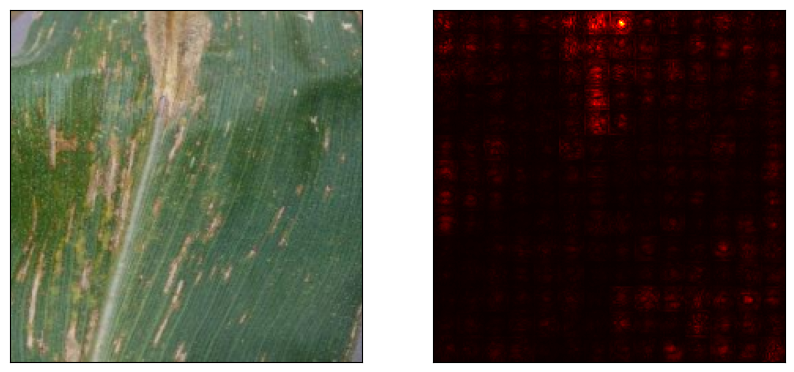

In [ ]:
img = Image.open("/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/color_corn/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/0140764c-6157-4995-9ada-9c10b81af3b8___RS_GLSp 4378.JPG").convert('RGB')
resized_image = img.resize((224, 224), Image.BILINEAR)
saliency(resized_image, model)

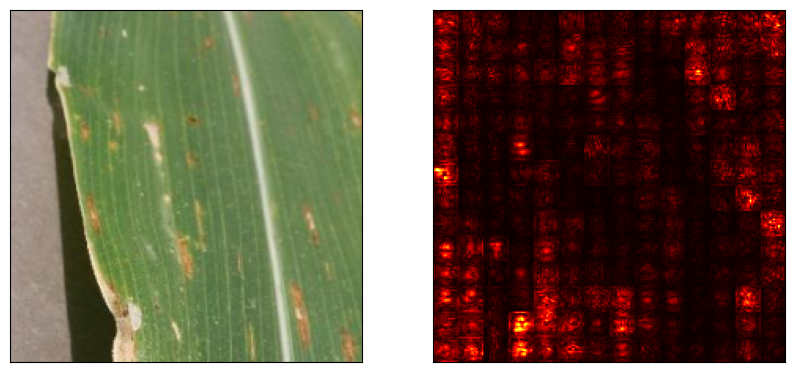

In [ ]:
path = "/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/color_corn/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/0157de0c-5b81-44a1-abe8-eecaa6f1261a___RS_GLSp 4287.JPG"
img = Image.open(path).convert('RGB')
resized_image = img.resize((224, 224), Image.BILINEAR)
saliency(resized_image, model)

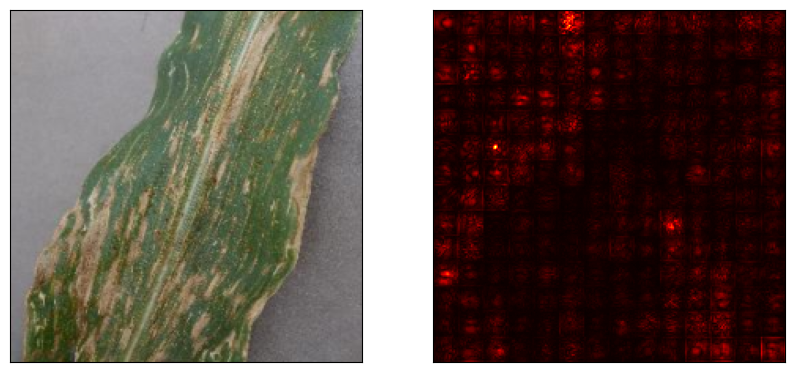

In [ ]:
path = "/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/color_corn/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/1f494486-8d19-45a2-8e34-0562e16b1307___RS_GLSp 4456.JPG"
img = Image.open(path).convert('RGB')
resized_image = img.resize((224, 224), Image.BILINEAR)
saliency(resized_image, model)

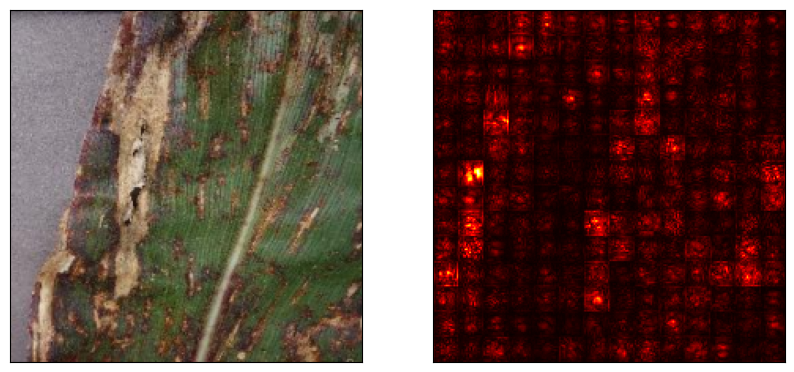

In [ ]:
path = "/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/color_corn/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/357866f9-d9f0-49a4-862e-6bfb2cb830c8___RS_GLSp 4291.JPG"
img = Image.open(path).convert('RGB')
resized_image = img.resize((224, 224), Image.BILINEAR)
saliency(resized_image, model)

### Saliency Maps: Common Rust

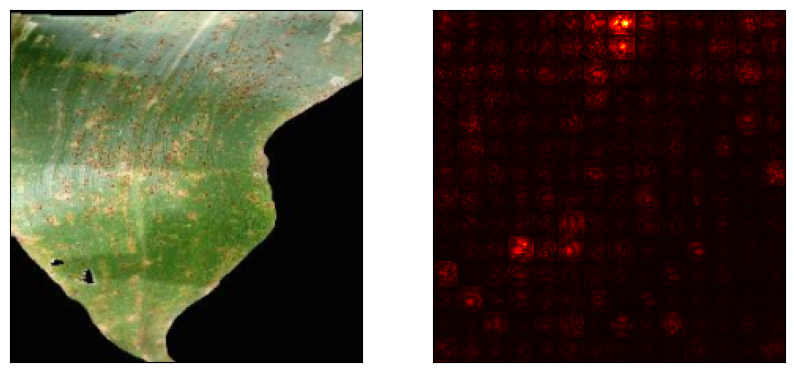

In [ ]:
path = "/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/color_corn/Corn_(maize)___Common_rust_/RS_Rust 1584.JPG"
img = Image.open(path).convert('RGB')
resized_image = img.resize((224, 224), Image.BILINEAR)
saliency(resized_image, model)

### Saliency Maps: Northern Leaf Blight

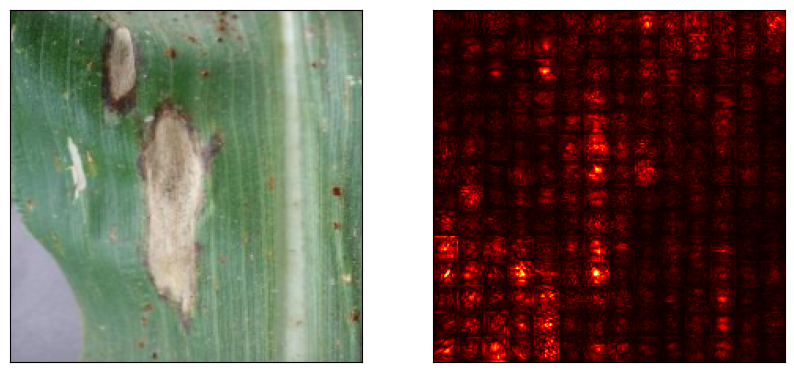

<Figure size 640x480 with 0 Axes>

In [ ]:
path = "/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/color_corn/Corn_(maize)___Northern_Leaf_Blight/02eee796-1a1e-4d63-8247-a6aac6bfb272___RS_NLB 3546.JPG"
img = Image.open(path).convert('RGB')
resized_image = img.resize((224, 224), Image.BILINEAR)
saliency(resized_image, model)


### Saliency Maps: Healthy

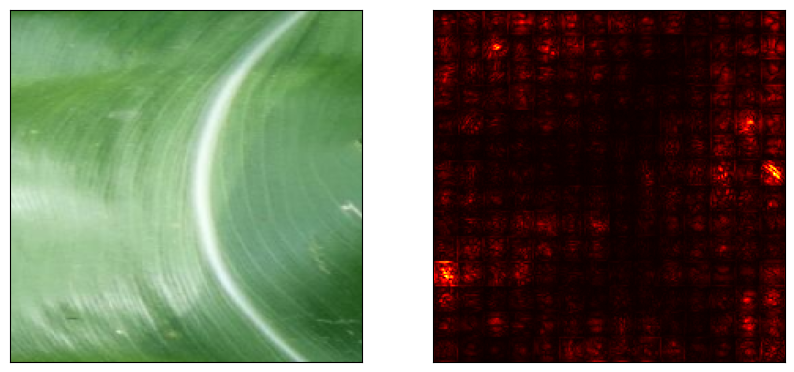

In [ ]:
path = "/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/color_corn/Corn_(maize)___healthy/00031d74-076e-4aef-b040-e068cd3576eb___R.S_HL 8315 copy 2.jpg"
img = Image.open(path).convert('RGB')
resized_image = img.resize((224, 224), Image.BILINEAR)
saliency(resized_image, model)

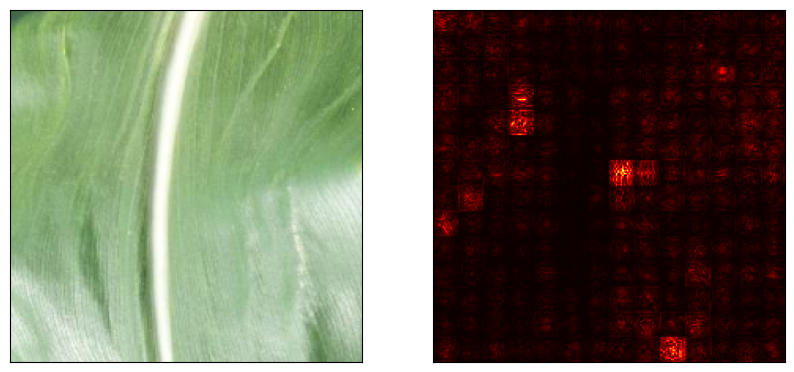

In [ ]:
path = "/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/color_corn/Corn_(maize)___healthy/04506233-3040-4d4b-9e8f-acdd0a1e9693___R.S_HL 7942 copy 2.jpg"
img = Image.open(path).convert('RGB')
resized_image = img.resize((224, 224), Image.BILINEAR)
saliency(resized_image, model)

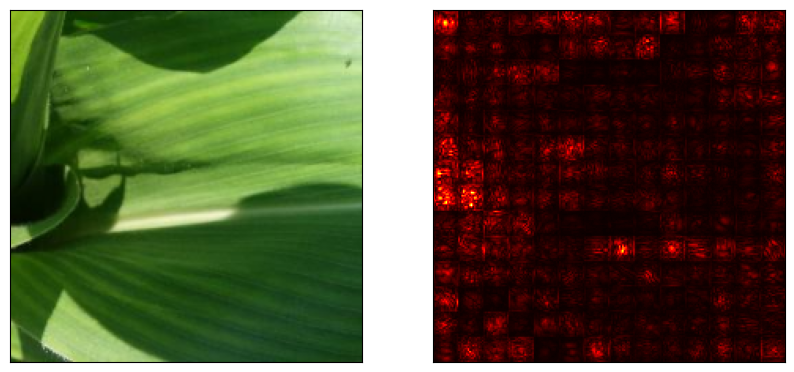

In [ ]:
path = "/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/color_corn/Corn_(maize)___healthy/06fc07d3-2c82-4538-9d0e-bff9808cd3fe___R.S_HL 0639 copy.jpg"
img = Image.open(path).convert('RGB')
resized_image = img.resize((224, 224), Image.BILINEAR)
saliency(resized_image, model)